In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [9]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [10]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [11]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [12]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [13]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [14]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [15]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [16]:
perceptual_ext = PerceptualLoss()

In [17]:
sobel_filter = Sobel().to(device)

In [18]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [19]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [20]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [21]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [23]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [24]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [25]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [26]:
train_case_path = 'raw/train/*_*'
train_id_case_path = "raw/train_id/*_*"
test_case_path = 'raw/test/*_*'

In [27]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(), identity=False)
trainset_id = Dataset(train_id_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(), identity=True)

trainset = ConcatDataset([trainset, trainset_id])
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation(), identity=False)

In [28]:
len(trainset), len(testset)

(1344, 191)

In [29]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f5721724610>,)

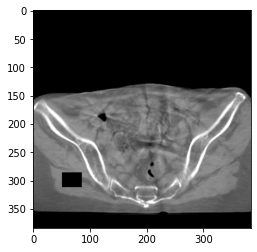

In [30]:
plt.imshow(x.squeeze(), 'gray'),

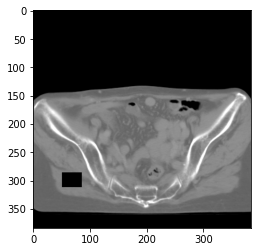

In [31]:
plt.imshow(y.squeeze(), 'gray')

In [32]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [37]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [38]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [39]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2, eta_min=3e-4)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2, eta_min=3e-4)

In [40]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [41]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [02:17,  2.44it/s]
336it [04:45,  1.18it/s]
336it [01:39,  3.37it/s]
48it [00:15,  3.17it/s]
336it [02:12,  2.54it/s]
336it [04:09,  1.35it/s]
336it [01:33,  3.59it/s]
48it [00:15,  3.14it/s]
336it [02:09,  2.58it/s]
336it [04:26,  1.26it/s]
336it [01:30,  3.70it/s]
48it [00:14,  3.27it/s]
336it [02:07,  2.63it/s]
336it [04:28,  1.25it/s]
336it [01:30,  3.73it/s]
48it [00:10,  4.38it/s]
336it [02:02,  2.75it/s]
336it [04:25,  1.26it/s]
336it [01:38,  3.43it/s]
48it [00:14,  3.31it/s]
336it [02:07,  2.64it/s]
336it [05:10,  1.08it/s]
336it [01:37,  3.46it/s]
48it [00:14,  3.20it/s]
336it [02:06,  2.65it/s]
336it [05:12,  1.07it/s]
336it [01:37,  3.46it/s]
48it [00:18,  2.62it/s]
336it [02:05,  2.69it/s]
336it [05:13,  1.07it/s]
336it [01:11,  4.70it/s]
48it [00:10,  4.45it/s]
336it [01:27,  3.84it/s]
336it [03:22,  1.66it/s]
336it [00:58,  5.73it/s]
48it [00:08,  5.54it/s]
336it [01:23,  4.00it/s]
336it [03:07,  1.79it/s]
336it [00:58,  5.74it/s]
48it [00:08,  5.55it/s]
336it [01:

In [42]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [43]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [44]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8925346732139587
psnr score = 25.965452194213867
snr score = 16.02838897705078
mae error = 0.017672637477517128
air dice score = 0.9955087166354816
bone dice score = 0.9410554167287806
contour dice score = 0.40047818422317505


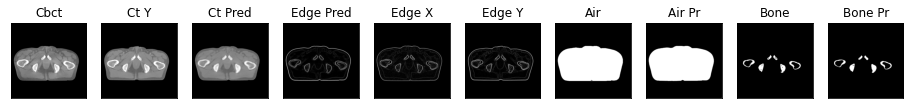

1it [00:01,  1.03s/it]

ssim score = 0.8935956954956055
psnr score = 25.832286834716797
snr score = 15.94275951385498
mae error = 0.018220581114292145
air dice score = 0.9951092785939962
bone dice score = 0.9319049016740255
contour dice score = 0.42155689001083374


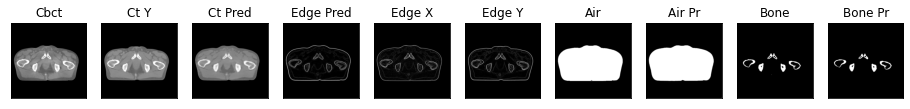

2it [00:02,  1.23s/it]

ssim score = 0.8923799991607666
psnr score = 25.47262954711914
snr score = 15.746000289916992
mae error = 0.019823739305138588
air dice score = 0.9951083158630376
bone dice score = 0.9063824322600953
contour dice score = 0.39208632707595825


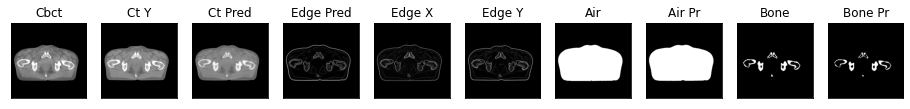

3it [00:03,  1.07s/it]

ssim score = 0.8894715905189514
psnr score = 25.388134002685547
snr score = 15.75075626373291
mae error = 0.020544564351439476
air dice score = 0.9954837691791943
bone dice score = 0.8689638726616314
contour dice score = 0.4468468427658081


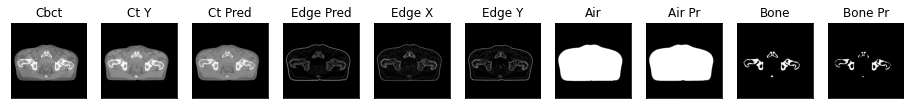

4it [00:04,  1.05it/s]

ssim score = 0.8898210525512695
psnr score = 25.411767959594727
snr score = 15.814691543579102
mae error = 0.020587170496582985
air dice score = 0.9960726898612126
bone dice score = 0.8402027771672889
contour dice score = 0.4659843444824219


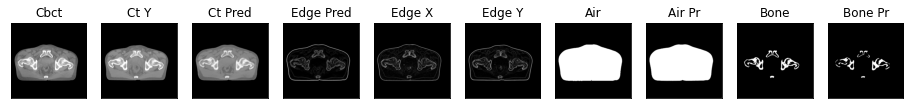

5it [00:04,  1.17it/s]

ssim score = 0.8824935555458069
psnr score = 24.964792251586914
snr score = 15.504251480102539
mae error = 0.022186899557709694
air dice score = 0.9961263408820062
bone dice score = 0.7975543478280517
contour dice score = 0.48400723934173584


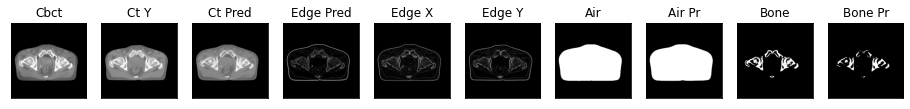

6it [00:05,  1.31it/s]

ssim score = 0.8804499506950378
psnr score = 24.7548828125
snr score = 15.270284652709961
mae error = 0.022188587114214897
air dice score = 0.995521791283491
bone dice score = 0.8071249652119202
contour dice score = 0.4631197154521942


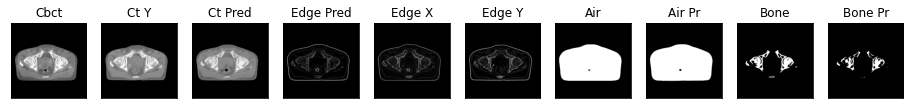

7it [00:05,  1.41it/s]

ssim score = 0.8823366761207581
psnr score = 25.40765953063965
snr score = 15.737525939941406
mae error = 0.020355917513370514
air dice score = 0.9952554230916193
bone dice score = 0.8431820438986674
contour dice score = 0.4199029207229614


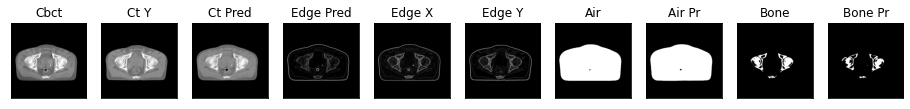

8it [00:06,  1.48it/s]

ssim score = 0.8864558935165405
psnr score = 25.956226348876953
snr score = 16.191537857055664
mae error = 0.019249359145760536
air dice score = 0.995329275936677
bone dice score = 0.8813559322046312
contour dice score = 0.3946406841278076


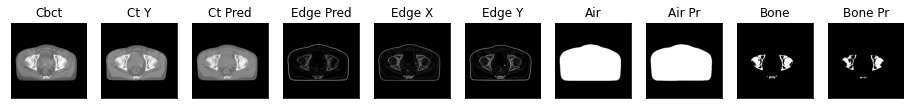

9it [00:07,  1.55it/s]

ssim score = 0.8911018967628479
psnr score = 25.937782287597656
snr score = 16.157808303833008
mae error = 0.019227037206292152
air dice score = 0.9946650376705409
bone dice score = 0.894384449245201
contour dice score = 0.3811850845813751


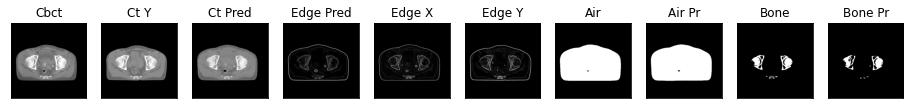

10it [00:07,  1.61it/s]

ssim score = 0.8966742753982544
psnr score = 26.156291961669922
snr score = 16.408586502075195
mae error = 0.019396210089325905
air dice score = 0.9950454508230335
bone dice score = 0.9090086011780328
contour dice score = 0.4043982923030853


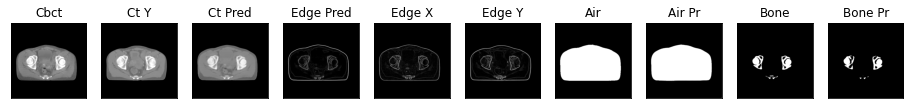

11it [00:08,  1.62it/s]

ssim score = 0.8953712582588196
psnr score = 25.094554901123047
snr score = 15.370561599731445
mae error = 0.02117922343313694
air dice score = 0.994669895778356
bone dice score = 0.9085518814149537
contour dice score = 0.3737744987010956


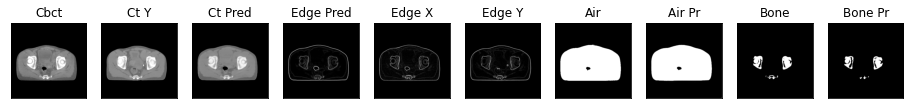

12it [00:09,  1.35it/s]

ssim score = 0.9001234769821167
psnr score = 24.45258331298828
snr score = 14.69666862487793
mae error = 0.0219890084117651
air dice score = 0.9942226780817677
bone dice score = 0.922629858337297
contour dice score = 0.3580625355243683


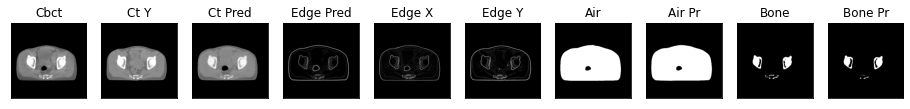

13it [00:09,  1.39it/s]

ssim score = 0.8963688611984253
psnr score = 24.43106460571289
snr score = 14.533190727233887
mae error = 0.021335158497095108
air dice score = 0.9943971384255068
bone dice score = 0.9149461108957935
contour dice score = 0.38689741492271423


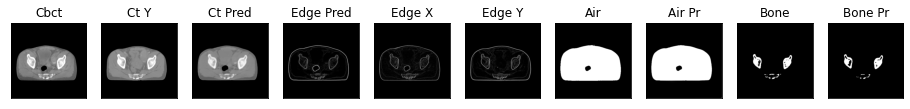

14it [00:10,  1.48it/s]

ssim score = 0.8927966356277466
psnr score = 24.315879821777344
snr score = 14.332345962524414
mae error = 0.02132132090628147
air dice score = 0.9946859852141042
bone dice score = 0.9059330276517169
contour dice score = 0.42618900537490845


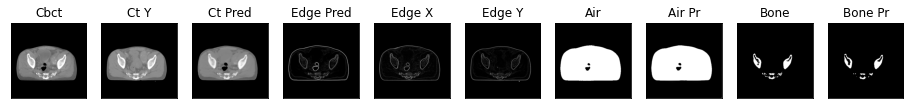

15it [00:11,  1.56it/s]

ssim score = 0.8865126371383667
psnr score = 24.088573455810547
snr score = 14.128523826599121
mae error = 0.022378256544470787
air dice score = 0.9952743138154366
bone dice score = 0.8987222595844153
contour dice score = 0.4646211564540863


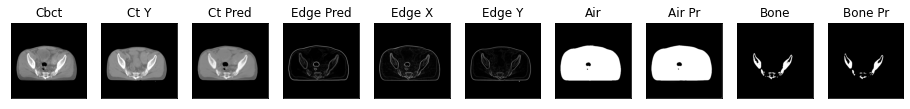

16it [00:11,  1.59it/s]

ssim score = 0.8834221363067627
psnr score = 23.392864227294922
snr score = 13.430270195007324
mae error = 0.023872554302215576
air dice score = 0.995132690834139
bone dice score = 0.8967363590018264
contour dice score = 0.45883092284202576


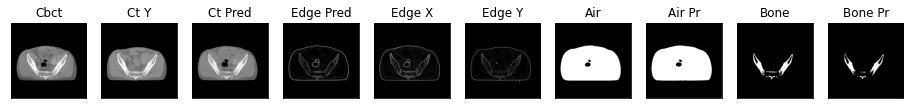

17it [00:12,  1.65it/s]

ssim score = 0.8750497102737427
psnr score = 22.917522430419922
snr score = 12.853169441223145
mae error = 0.024763217195868492
air dice score = 0.9937186477644562
bone dice score = 0.8978296738177709
contour dice score = 0.4081885814666748


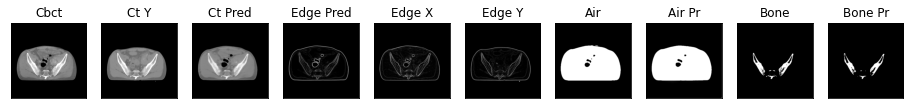

18it [00:12,  1.67it/s]

ssim score = 0.872469961643219
psnr score = 22.627412796020508
snr score = 12.512378692626953
mae error = 0.025394441559910774
air dice score = 0.9932944926899051
bone dice score = 0.8822205551402573
contour dice score = 0.4326739013195038


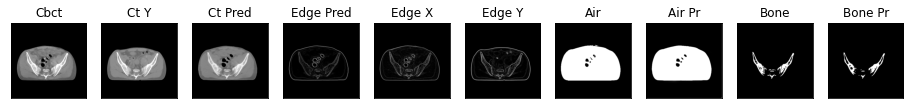

19it [00:13,  1.69it/s]

ssim score = 0.8762076497077942
psnr score = 22.804195404052734
snr score = 12.676850318908691
mae error = 0.025281144306063652
air dice score = 0.9935165516020606
bone dice score = 0.8834547346529207
contour dice score = 0.38451775908470154


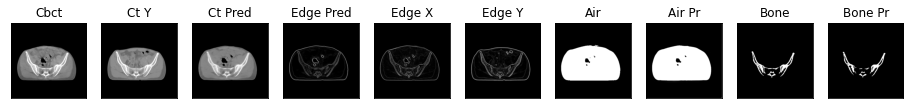

20it [00:13,  1.72it/s]

ssim score = 0.8737448453903198
psnr score = 22.803985595703125
snr score = 12.611794471740723
mae error = 0.025191567838191986
air dice score = 0.9936608557844762
bone dice score = 0.8761111111128318
contour dice score = 0.3602564036846161


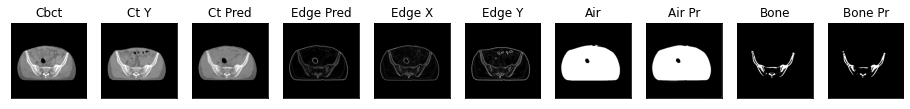

21it [00:14,  1.75it/s]

ssim score = 0.8690186738967896
psnr score = 22.739622116088867
snr score = 12.488001823425293
mae error = 0.02502010017633438
air dice score = 0.992073753443148
bone dice score = 0.8931454371337646
contour dice score = 0.32149773836135864


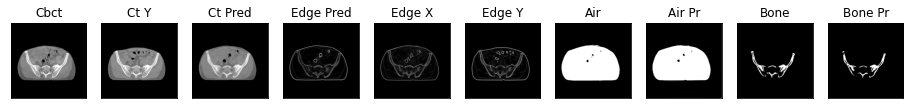

22it [00:15,  1.30it/s]

ssim score = 0.8737762570381165
psnr score = 22.996257781982422
snr score = 12.711210250854492
mae error = 0.024273822084069252
air dice score = 0.9927413583542618
bone dice score = 0.889728884255869
contour dice score = 0.2883116900920868


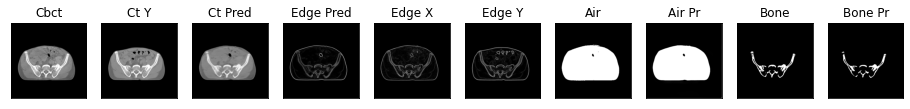

23it [00:16,  1.38it/s]

ssim score = 0.8732842803001404
psnr score = 23.009565353393555
snr score = 12.675951957702637
mae error = 0.024153169244527817
air dice score = 0.988159802701451
bone dice score = 0.8721019108296547
contour dice score = 0.27453580498695374


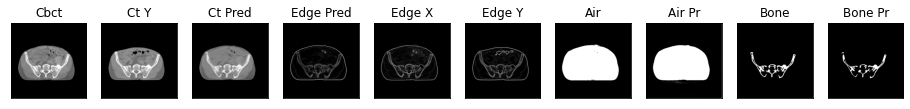

24it [00:16,  1.44it/s]

ssim score = 0.8705359697341919
psnr score = 22.783601760864258
snr score = 12.352989196777344
mae error = 0.02417035959661007
air dice score = 0.9819716945223226
bone dice score = 0.872549019609405
contour dice score = 0.2740094065666199


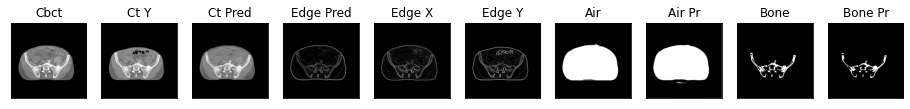

25it [00:17,  1.51it/s]

ssim score = 0.8716279864311218
psnr score = 22.81275177001953
snr score = 12.299405097961426
mae error = 0.02384369447827339
air dice score = 0.9833431638551571
bone dice score = 0.8580809923402883
contour dice score = 0.27501702308654785


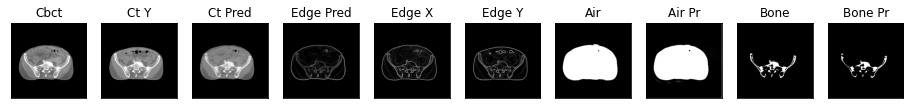

26it [00:18,  1.55it/s]

ssim score = 0.8687941431999207
psnr score = 22.842918395996094
snr score = 12.238384246826172
mae error = 0.0237549040466547
air dice score = 0.9803069237974251
bone dice score = 0.8713274973033777
contour dice score = 0.24563851952552795


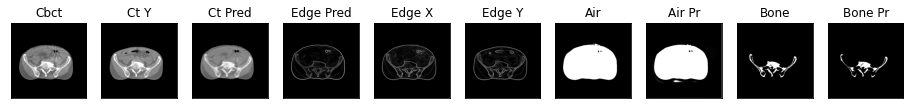

27it [00:18,  1.67it/s]

ssim score = 0.866787850856781
psnr score = 22.6702880859375
snr score = 12.024646759033203
mae error = 0.0241294763982296
air dice score = 0.9772360289922211
bone dice score = 0.8549671977524019
contour dice score = 0.25350141525268555


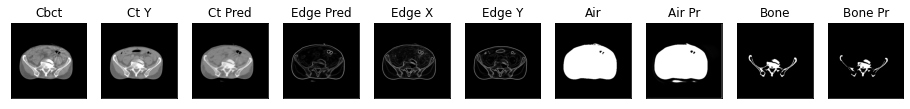

28it [00:19,  1.83it/s]

ssim score = 0.8622633218765259
psnr score = 23.756881713867188
snr score = 15.129037857055664
mae error = 0.023759352043271065
air dice score = 0.9937155348005404
bone dice score = 0.948260211801868
contour dice score = 0.17817561328411102


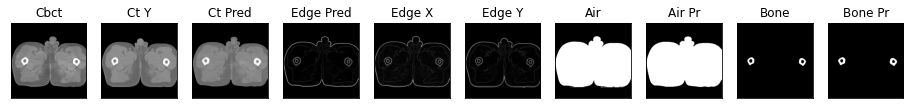

29it [00:19,  1.95it/s]

ssim score = 0.8681910634040833
psnr score = 24.360157012939453
snr score = 15.771571159362793
mae error = 0.02246272563934326
air dice score = 0.992833547609239
bone dice score = 0.9505962521308746
contour dice score = 0.1666666716337204


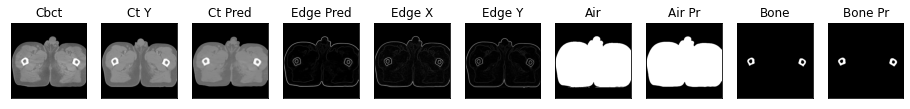

30it [00:19,  1.99it/s]

ssim score = 0.8759371042251587
psnr score = 25.01175880432129
snr score = 16.510622024536133
mae error = 0.021722853183746338
air dice score = 0.9932148942537341
bone dice score = 0.9549590536861929
contour dice score = 0.1827094405889511


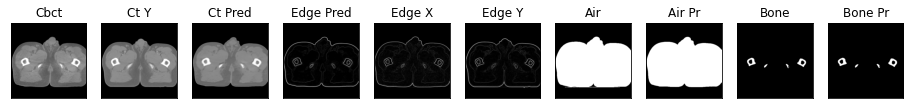

31it [00:20,  1.79it/s]

ssim score = 0.8801899552345276
psnr score = 25.423736572265625
snr score = 17.08515739440918
mae error = 0.022123031318187714
air dice score = 0.9942510244346673
bone dice score = 0.9569270331090176
contour dice score = 0.1844167858362198


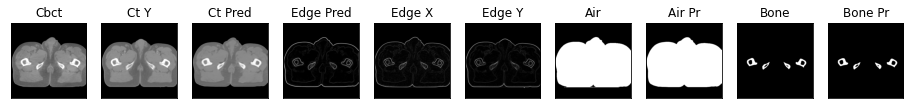

32it [00:21,  1.95it/s]

ssim score = 0.881183922290802
psnr score = 25.696428298950195
snr score = 17.485992431640625
mae error = 0.02213140018284321
air dice score = 0.9943004962134296
bone dice score = 0.9389238294907208
contour dice score = 0.1824953407049179


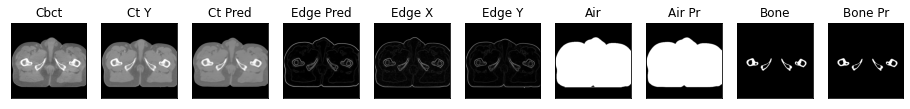

33it [00:21,  1.96it/s]

ssim score = 0.8809292316436768
psnr score = 26.044750213623047
snr score = 17.937551498413086
mae error = 0.02202485129237175
air dice score = 0.9944729427064551
bone dice score = 0.9275470756961274
contour dice score = 0.19078640639781952


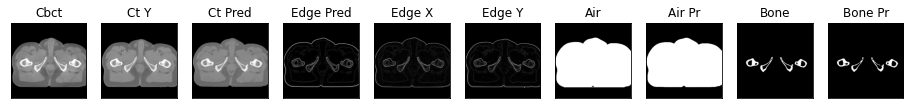

34it [00:22,  2.00it/s]

ssim score = 0.8837467432022095
psnr score = 26.376819610595703
snr score = 18.33672332763672
mae error = 0.02215024270117283
air dice score = 0.9943318478176149
bone dice score = 0.911693408750875
contour dice score = 0.17961843311786652


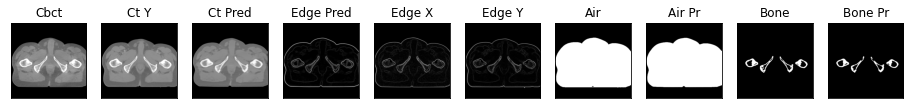

35it [00:22,  1.77it/s]

ssim score = 0.8814899325370789
psnr score = 26.513446807861328
snr score = 18.46346092224121
mae error = 0.021573344245553017
air dice score = 0.9944384642985322
bone dice score = 0.9155457552379763
contour dice score = 0.18004640936851501


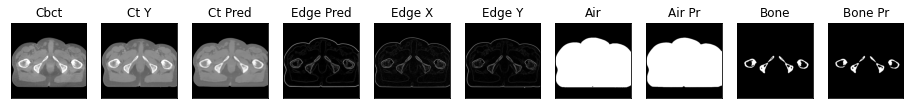

36it [00:23,  1.60it/s]

ssim score = 0.8835375308990479
psnr score = 26.729537963867188
snr score = 18.66588592529297
mae error = 0.021075662225484848
air dice score = 0.9943243194853129
bone dice score = 0.9186750302639081
contour dice score = 0.17354989051818848


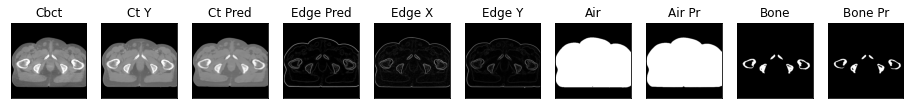

37it [00:24,  1.55it/s]

ssim score = 0.889650821685791
psnr score = 27.143627166748047
snr score = 19.091976165771484
mae error = 0.020990634337067604
air dice score = 0.9945882801697453
bone dice score = 0.9138706329999553
contour dice score = 0.18308550119400024


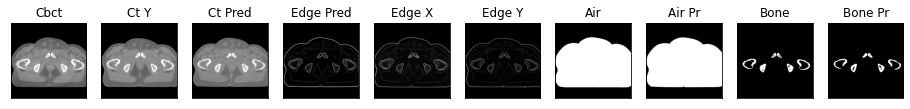

38it [00:24,  1.54it/s]

ssim score = 0.891579806804657
psnr score = 27.1015625
snr score = 19.0889949798584
mae error = 0.021123340353369713
air dice score = 0.9945244493169
bone dice score = 0.9133932796981377
contour dice score = 0.17257462441921234


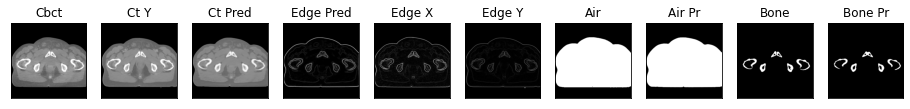

39it [00:25,  1.49it/s]

ssim score = 0.888306200504303
psnr score = 26.59050941467285
snr score = 18.719236373901367
mae error = 0.02299962379038334
air dice score = 0.9947272153143147
bone dice score = 0.8785676671945385
contour dice score = 0.16923795640468597


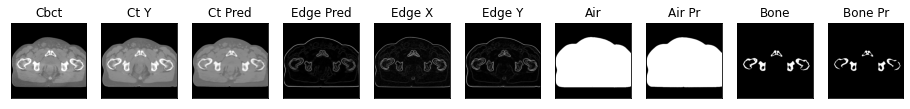

40it [00:26,  1.48it/s]

ssim score = 0.8848809003829956
psnr score = 26.124984741210938
snr score = 18.34839630126953
mae error = 0.02504769340157509
air dice score = 0.9947269842406053
bone dice score = 0.8410859728521168
contour dice score = 0.17900656163692474


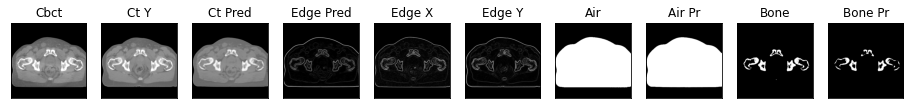

41it [00:27,  1.08it/s]

ssim score = 0.8748019933700562
psnr score = 25.274646759033203
snr score = 17.464008331298828
mae error = 0.026044942438602448
air dice score = 0.9949081248616368
bone dice score = 0.794622581526073
contour dice score = 0.18890976905822754


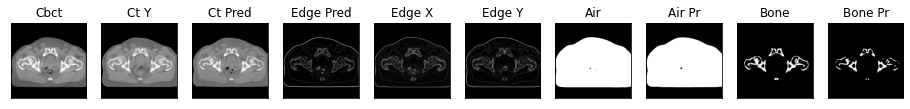

42it [00:28,  1.15it/s]

ssim score = 0.8690922856330872
psnr score = 24.058246612548828
snr score = 16.319795608520508
mae error = 0.028631895780563354
air dice score = 0.994485382651836
bone dice score = 0.7395623031596579
contour dice score = 0.1956726312637329


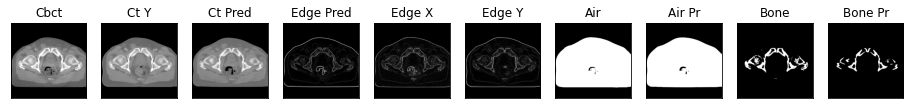

43it [00:29,  1.18it/s]

ssim score = 0.8705488443374634
psnr score = 24.42050552368164
snr score = 16.54595947265625
mae error = 0.027066463604569435
air dice score = 0.9949078520558898
bone dice score = 0.7860297069471494
contour dice score = 0.20963172614574432


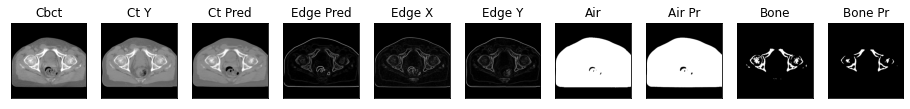

44it [00:29,  1.35it/s]

ssim score = 0.8735229969024658
psnr score = 25.04148292541504
snr score = 16.988374710083008
mae error = 0.02418469823896885
air dice score = 0.9951550387596929
bone dice score = 0.837115588548917
contour dice score = 0.22053951025009155


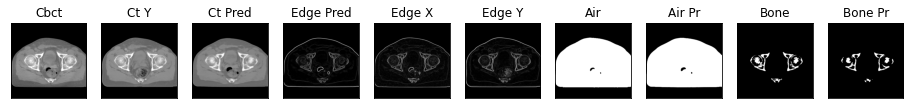

45it [00:30,  1.46it/s]

ssim score = 0.8743837475776672
psnr score = 25.407859802246094
snr score = 17.26416778564453
mae error = 0.023597467690706253
air dice score = 0.995579755401008
bone dice score = 0.8414648414666962
contour dice score = 0.21302901208400726


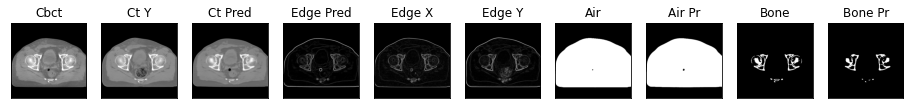

46it [00:30,  1.58it/s]

ssim score = 0.8759674429893494
psnr score = 25.441593170166016
snr score = 17.313589096069336
mae error = 0.023535294458270073
air dice score = 0.9961526286312634
bone dice score = 0.8593647316554286
contour dice score = 0.22857142984867096


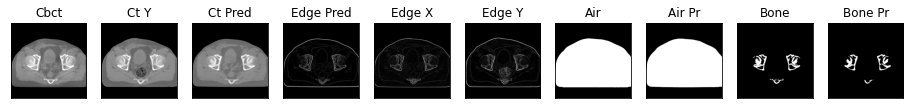

47it [00:31,  1.59it/s]

ssim score = 0.867292582988739
psnr score = 25.20937728881836
snr score = 17.091405868530273
mae error = 0.02445501834154129
air dice score = 0.9960719049425494
bone dice score = 0.8435291742394152
contour dice score = 0.2386634796857834


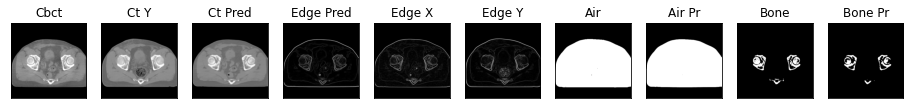

48it [00:32,  1.63it/s]

ssim score = 0.8721595406532288
psnr score = 25.25935935974121
snr score = 17.202980041503906
mae error = 0.024777526035904884
air dice score = 0.9960709198958818
bone dice score = 0.8433249370292865
contour dice score = 0.24630071222782135


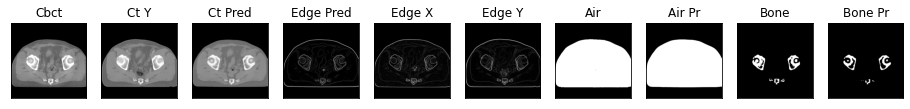

49it [00:32,  1.58it/s]

ssim score = 0.8744499087333679
psnr score = 25.643577575683594
snr score = 17.657278060913086
mae error = 0.024875203147530556
air dice score = 0.9959086238825646
bone dice score = 0.8768283294854039
contour dice score = 0.24690181016921997


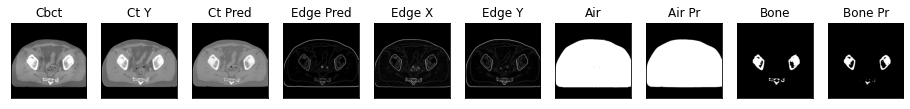

50it [00:33,  1.55it/s]

ssim score = 0.8797538876533508
psnr score = 25.783823013305664
snr score = 17.678417205810547
mae error = 0.023733317852020264
air dice score = 0.9959330334894105
bone dice score = 0.8580366774556846
contour dice score = 0.23714286088943481


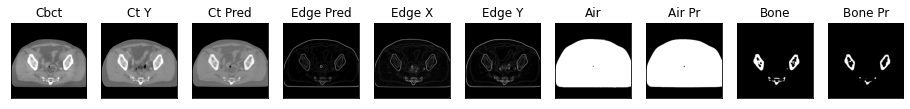

51it [00:34,  1.32it/s]

ssim score = 0.8738681674003601
psnr score = 24.885042190551758
snr score = 16.861265182495117
mae error = 0.02598574385046959
air dice score = 0.9954675997958295
bone dice score = 0.8624883068300984
contour dice score = 0.23264719545841217


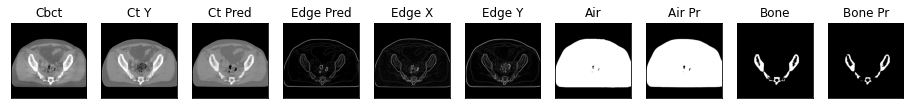

52it [00:34,  1.44it/s]

ssim score = 0.8738182187080383
psnr score = 24.89813804626465
snr score = 16.95450782775879
mae error = 0.026679402217268944
air dice score = 0.994892822943014
bone dice score = 0.823567550046004
contour dice score = 0.20249520242214203


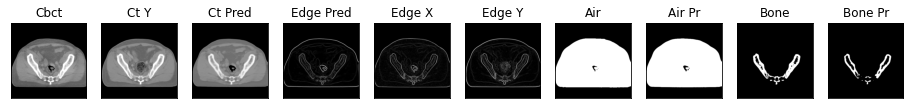

53it [00:35,  1.53it/s]

ssim score = 0.8540982604026794
psnr score = 24.295257568359375
snr score = 16.373188018798828
mae error = 0.028452174738049507
air dice score = 0.9949965398347725
bone dice score = 0.817274660560958
contour dice score = 0.1783132553100586


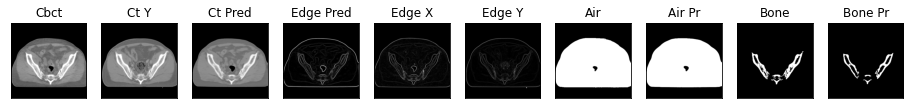

54it [00:36,  1.53it/s]

ssim score = 0.8540041446685791
psnr score = 24.913415908813477
snr score = 17.003883361816406
mae error = 0.027608653530478477
air dice score = 0.9950255404182463
bone dice score = 0.8272234095033106
contour dice score = 0.16346153616905212


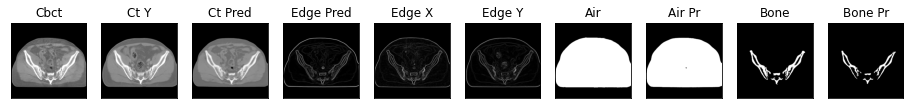

55it [00:36,  1.54it/s]

ssim score = 0.813407838344574
psnr score = 21.04627227783203
snr score = 10.926477432250977
mae error = 0.031446024775505066
air dice score = 0.9959106412614548
bone dice score = 0.9153652392968422
contour dice score = 0.5423353910446167


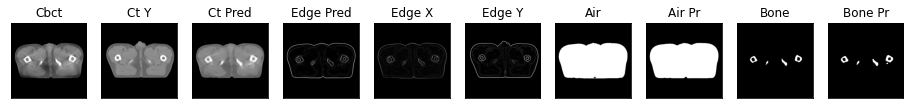

56it [00:37,  1.54it/s]

ssim score = 0.8034417033195496
psnr score = 20.708763122558594
snr score = 10.801950454711914
mae error = 0.033655159175395966
air dice score = 0.9960846983619691
bone dice score = 0.9090539165837426
contour dice score = 0.5319383144378662


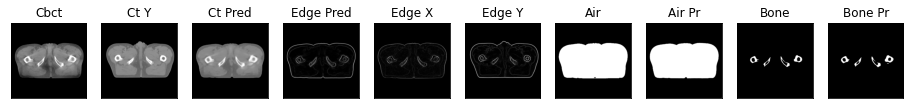

57it [00:38,  1.57it/s]

ssim score = 0.7992002964019775
psnr score = 20.701324462890625
snr score = 10.925653457641602
mae error = 0.03423186019062996
air dice score = 0.9962028222744245
bone dice score = 0.8830822048467846
contour dice score = 0.5397695899009705


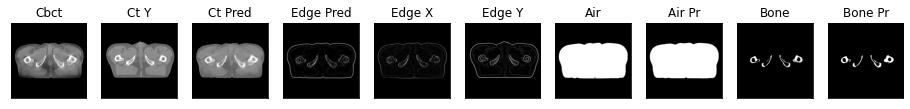

58it [00:38,  1.66it/s]

ssim score = 0.8043186068534851
psnr score = 21.013893127441406
snr score = 11.308623313903809
mae error = 0.03324444591999054
air dice score = 0.9958967780482055
bone dice score = 0.8681123355871292
contour dice score = 0.4969896078109741


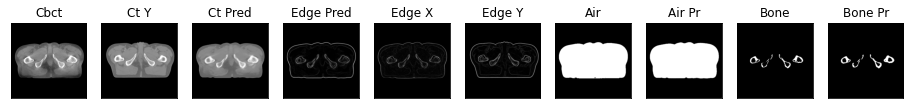

59it [00:39,  1.74it/s]

ssim score = 0.8066105246543884
psnr score = 21.13386344909668
snr score = 11.47615909576416
mae error = 0.032840095460414886
air dice score = 0.9958868624636855
bone dice score = 0.8768267223403475
contour dice score = 0.49891066551208496


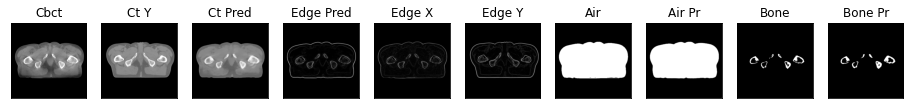

60it [00:39,  1.83it/s]

ssim score = 0.8070906400680542
psnr score = 21.285741806030273
snr score = 11.633651733398438
mae error = 0.03203325718641281
air dice score = 0.9953514333807243
bone dice score = 0.9004706292504712
contour dice score = 0.5029177665710449


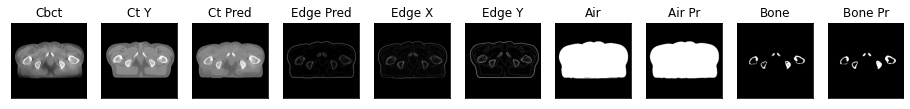

61it [00:40,  1.65it/s]

ssim score = 0.8062595129013062
psnr score = 21.343170166015625
snr score = 11.684578895568848
mae error = 0.031783003360033035
air dice score = 0.9950073063809103
bone dice score = 0.8879901529824513
contour dice score = 0.5331917405128479


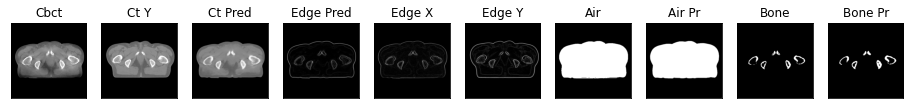

62it [00:40,  1.72it/s]

ssim score = 0.8060469627380371
psnr score = 21.238525390625
snr score = 11.594043731689453
mae error = 0.032213691622018814
air dice score = 0.9955342819732442
bone dice score = 0.8913494809707379
contour dice score = 0.5015906691551208


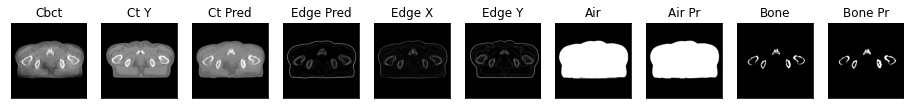

63it [00:41,  1.39it/s]

ssim score = 0.8043845295906067
psnr score = 21.152328491210938
snr score = 11.565857887268066
mae error = 0.033112939447164536
air dice score = 0.9952611562085826
bone dice score = 0.8919993637682202
contour dice score = 0.5581643581390381


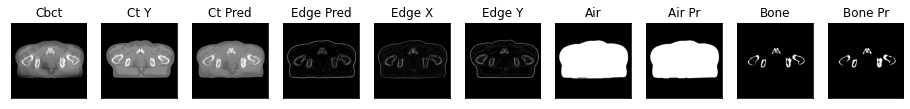

64it [00:43,  1.16it/s]

ssim score = 0.7971954345703125
psnr score = 21.002498626708984
snr score = 11.514583587646484
mae error = 0.03449840098619461
air dice score = 0.9946703291957166
bone dice score = 0.8620689655193647
contour dice score = 0.5258711576461792


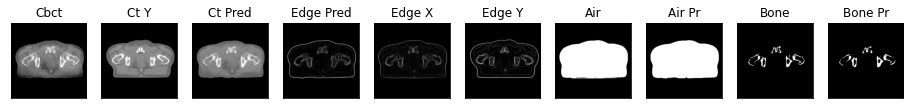

65it [00:44,  1.05it/s]

ssim score = 0.7868334650993347
psnr score = 20.828067779541016
snr score = 11.375982284545898
mae error = 0.03595355525612831
air dice score = 0.9949120386340161
bone dice score = 0.8619963920646122
contour dice score = 0.49220848083496094


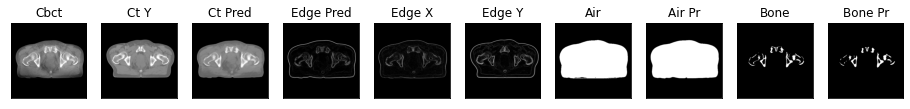

66it [00:45,  1.08it/s]

ssim score = 0.7745893597602844
psnr score = 20.72854995727539
snr score = 11.309171676635742
mae error = 0.03661954402923584
air dice score = 0.9950816141952753
bone dice score = 0.8322314049609886
contour dice score = 0.5182012915611267


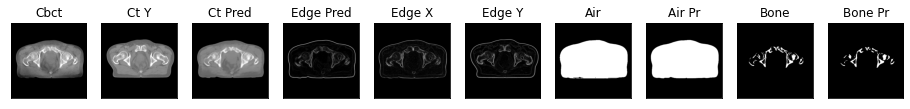

67it [00:45,  1.16it/s]

ssim score = 0.7746379971504211
psnr score = 20.726600646972656
snr score = 11.42403793334961
mae error = 0.03688444942235947
air dice score = 0.9953846418792125
bone dice score = 0.8718150774905199
contour dice score = 0.5806111693382263


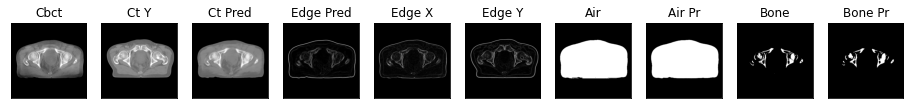

68it [00:46,  1.29it/s]

ssim score = 0.7776917815208435
psnr score = 20.770301818847656
snr score = 11.451753616333008
mae error = 0.03633064776659012
air dice score = 0.9957722345161355
bone dice score = 0.8551055333734298
contour dice score = 0.5603917241096497


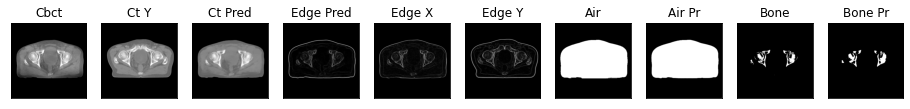

69it [00:46,  1.40it/s]

ssim score = 0.7937737107276917
psnr score = 21.415843963623047
snr score = 11.898130416870117
mae error = 0.03263121098279953
air dice score = 0.9958107887244017
bone dice score = 0.8767605633820897
contour dice score = 0.533261775970459


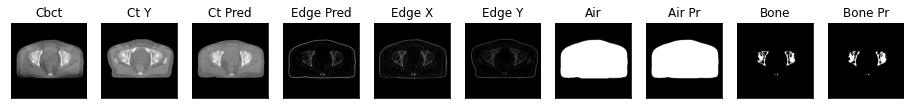

70it [00:47,  1.51it/s]

ssim score = 0.8099666237831116
psnr score = 22.16950225830078
snr score = 12.481395721435547
mae error = 0.029462477192282677
air dice score = 0.9953528325387662
bone dice score = 0.904493610005435
contour dice score = 0.4978494644165039


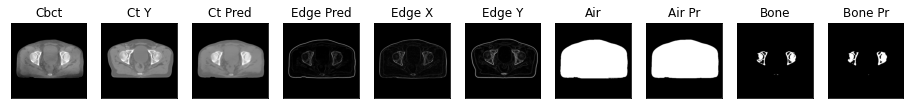

71it [00:48,  1.36it/s]

ssim score = 0.8173025250434875
psnr score = 22.5850772857666
snr score = 12.911140441894531
mae error = 0.02817479707300663
air dice score = 0.9951400138856787
bone dice score = 0.9191176470598855
contour dice score = 0.49652963876724243


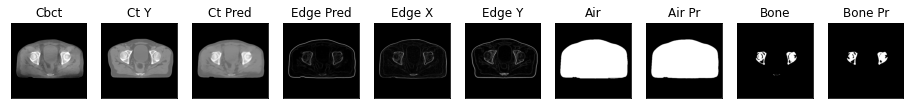

72it [00:48,  1.50it/s]

ssim score = 0.8246562480926514
psnr score = 22.81622314453125
snr score = 13.224116325378418
mae error = 0.02773628570139408
air dice score = 0.9955622440167288
bone dice score = 0.9391588403438252
contour dice score = 0.5260303616523743


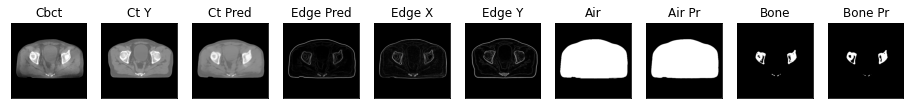

73it [00:49,  1.61it/s]

ssim score = 0.8247838616371155
psnr score = 22.814125061035156
snr score = 13.314191818237305
mae error = 0.02800448052585125
air dice score = 0.995805340517686
bone dice score = 0.9314787701327748
contour dice score = 0.5250412821769714


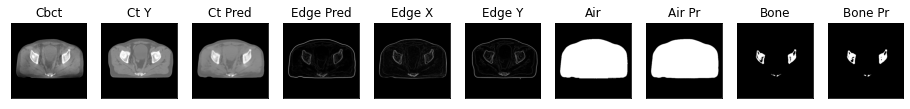

74it [00:49,  1.70it/s]

ssim score = 0.8176261782646179
psnr score = 23.135221481323242
snr score = 13.571858406066895
mae error = 0.027100512757897377
air dice score = 0.9958286253154054
bone dice score = 0.9448051948060908
contour dice score = 0.48686328530311584


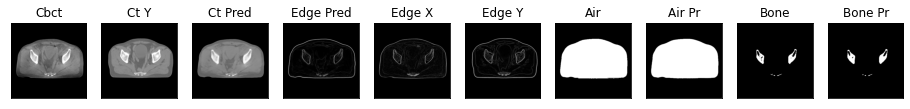

75it [00:50,  1.72it/s]

ssim score = 0.824320375919342
psnr score = 23.23199462890625
snr score = 13.632238388061523
mae error = 0.02643280290067196
air dice score = 0.9955928432529779
bone dice score = 0.9461390970900098
contour dice score = 0.4513038992881775


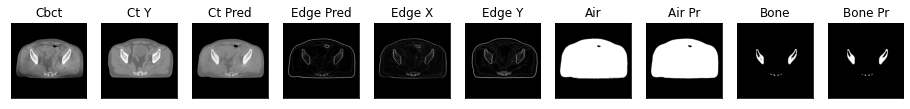

76it [00:51,  1.75it/s]

ssim score = 0.8194285035133362
psnr score = 22.925315856933594
snr score = 13.363304138183594
mae error = 0.028085792437195778
air dice score = 0.9955240740268934
bone dice score = 0.9127278593335582
contour dice score = 0.48594164848327637


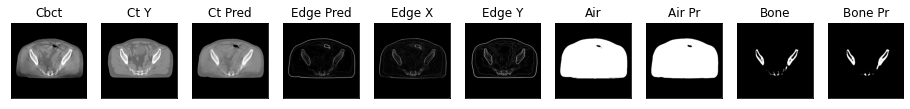

77it [00:51,  1.83it/s]

ssim score = 0.816550076007843
psnr score = 22.866621017456055
snr score = 13.435115814208984
mae error = 0.028570502996444702
air dice score = 0.9956145569512709
bone dice score = 0.9141122035871296
contour dice score = 0.4829059839248657


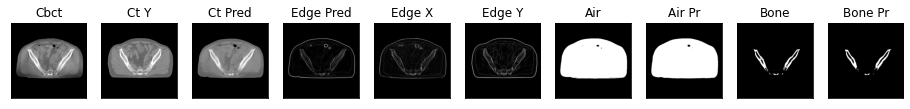

78it [00:52,  1.91it/s]

ssim score = 0.8191744685173035
psnr score = 22.698532104492188
snr score = 13.284774780273438
mae error = 0.0294170081615448
air dice score = 0.9958782417244857
bone dice score = 0.8892994611256458
contour dice score = 0.44897958636283875


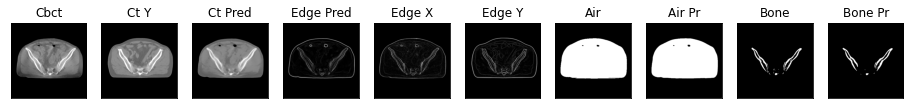

79it [00:52,  1.89it/s]

ssim score = 0.8233567476272583
psnr score = 23.12511444091797
snr score = 13.700089454650879
mae error = 0.028371000662446022
air dice score = 0.9957821099737704
bone dice score = 0.878088164058161
contour dice score = 0.4635332226753235


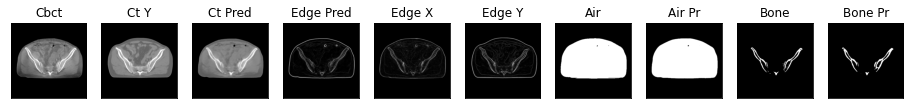

80it [00:53,  1.92it/s]

ssim score = 0.8230940103530884
psnr score = 23.189193725585938
snr score = 13.763427734375
mae error = 0.028049392625689507
air dice score = 0.995722928374114
bone dice score = 0.8739068214362553
contour dice score = 0.4534060060977936


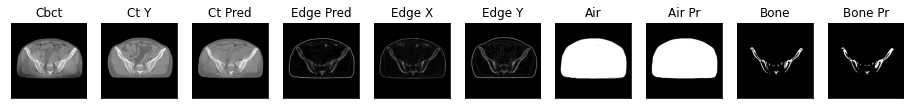

81it [00:53,  1.59it/s]

ssim score = 0.8626795411109924
psnr score = 23.813905715942383
snr score = 14.248038291931152
mae error = 0.02121305651962757
air dice score = 0.9954371410338262
bone dice score = 0.8630733177146611
contour dice score = 0.3682810068130493


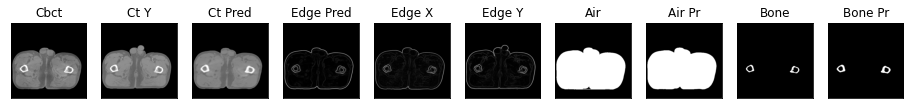

82it [00:54,  1.67it/s]

ssim score = 0.8650572299957275
psnr score = 24.087459564208984
snr score = 14.585986137390137
mae error = 0.021059352904558182
air dice score = 0.9950288989843771
bone dice score = 0.8517732646301373
contour dice score = 0.29699841141700745


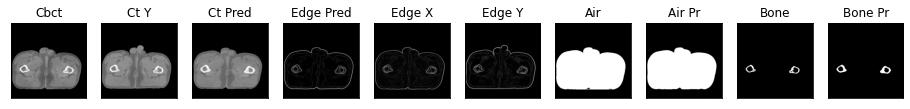

83it [00:55,  1.76it/s]

ssim score = 0.8727765083312988
psnr score = 25.467374801635742
snr score = 16.105112075805664
mae error = 0.020023150369524956
air dice score = 0.9957064059170148
bone dice score = 0.9067389943687306
contour dice score = 0.3211009204387665


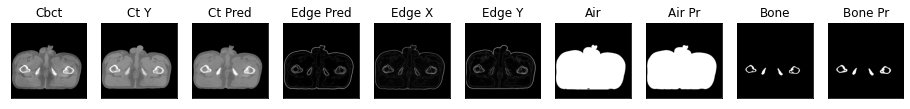

84it [00:55,  1.83it/s]

ssim score = 0.8724269270896912
psnr score = 25.50872039794922
snr score = 16.26795196533203
mae error = 0.020518289878964424
air dice score = 0.9964454422150535
bone dice score = 0.8689282960703754
contour dice score = 0.3451828956604004


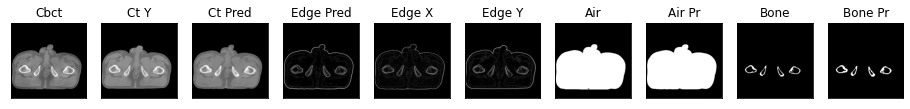

85it [00:56,  1.83it/s]

ssim score = 0.8681796789169312
psnr score = 25.417705535888672
snr score = 16.201107025146484
mae error = 0.020728079602122307
air dice score = 0.9966482879828319
bone dice score = 0.849910304966117
contour dice score = 0.3359334468841553


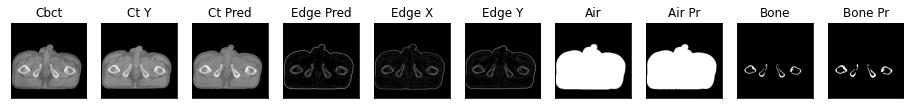

86it [00:56,  1.87it/s]

ssim score = 0.8684431314468384
psnr score = 25.259382247924805
snr score = 16.03839111328125
mae error = 0.020997032523155212
air dice score = 0.996823374989323
bone dice score = 0.8538139450235971
contour dice score = 0.3298429250717163


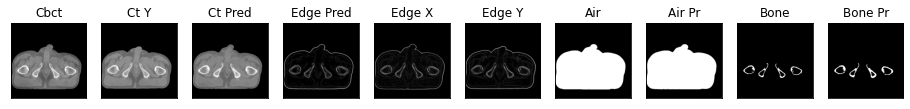

87it [00:57,  1.87it/s]

ssim score = 0.8693155646324158
psnr score = 24.931278228759766
snr score = 15.716538429260254
mae error = 0.021420665085315704
air dice score = 0.996678617435709
bone dice score = 0.8571943743264119
contour dice score = 0.3354363739490509


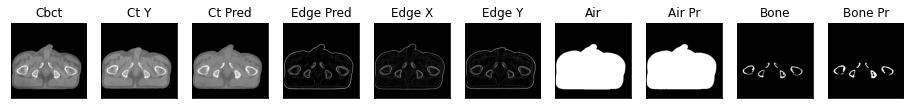

88it [00:57,  1.91it/s]

ssim score = 0.866147518157959
psnr score = 24.73415756225586
snr score = 15.497864723205566
mae error = 0.021422533318400383
air dice score = 0.9970408456502008
bone dice score = 0.8627873563243034
contour dice score = 0.3574064373970032


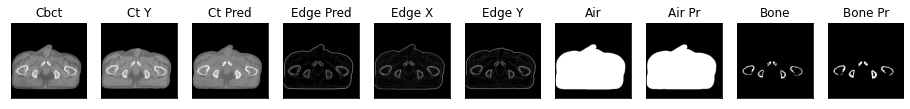

89it [00:58,  1.93it/s]

ssim score = 0.8668529987335205
psnr score = 24.748641967773438
snr score = 15.52925968170166
mae error = 0.021359682083129883
air dice score = 0.9969087497177409
bone dice score = 0.8882671795788029
contour dice score = 0.331919401884079


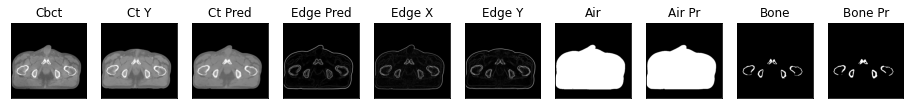

90it [00:58,  1.94it/s]

ssim score = 0.8673866987228394
psnr score = 24.953479766845703
snr score = 15.802689552307129
mae error = 0.0215709637850523
air dice score = 0.9971472116925264
bone dice score = 0.877484522647809
contour dice score = 0.32461291551589966


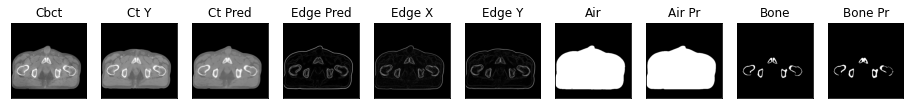

91it [00:59,  1.61it/s]

ssim score = 0.8690912127494812
psnr score = 25.27482032775879
snr score = 16.20538902282715
mae error = 0.021732861176133156
air dice score = 0.9973160050854661
bone dice score = 0.8772090188927908
contour dice score = 0.3612903356552124


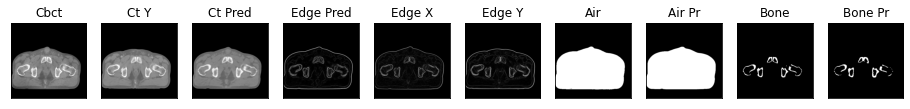

92it [00:59,  1.70it/s]

ssim score = 0.8701143860816956
psnr score = 25.37836456298828
snr score = 16.359636306762695
mae error = 0.02220296673476696
air dice score = 0.9976520642924696
bone dice score = 0.8595090210017818
contour dice score = 0.393760085105896


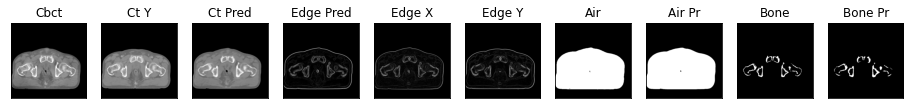

93it [01:00,  1.75it/s]

ssim score = 0.8720937371253967
psnr score = 25.59467124938965
snr score = 16.692211151123047
mae error = 0.02253575809299946
air dice score = 0.9978353268340487
bone dice score = 0.8240147958482854
contour dice score = 0.3875134587287903


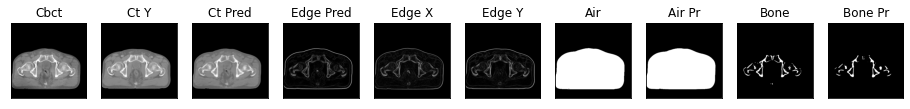

94it [01:01,  1.77it/s]

ssim score = 0.8702380657196045
psnr score = 25.125282287597656
snr score = 16.184585571289062
mae error = 0.022840075194835663
air dice score = 0.9976010040830612
bone dice score = 0.8169178984367493
contour dice score = 0.4448034465312958


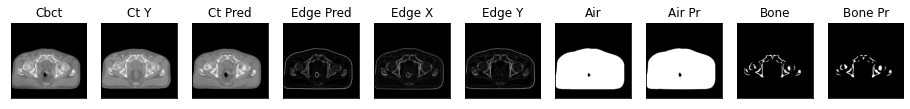

95it [01:01,  1.83it/s]

ssim score = 0.8619359731674194
psnr score = 24.32898712158203
snr score = 15.292619705200195
mae error = 0.023438140749931335
air dice score = 0.9962989665945716
bone dice score = 0.8272486772509623
contour dice score = 0.409066379070282


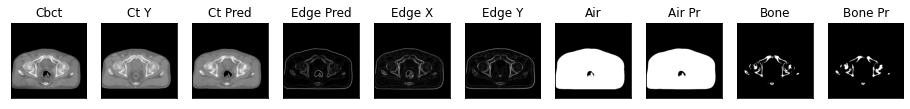

96it [01:02,  1.87it/s]

ssim score = 0.8672688007354736
psnr score = 24.228649139404297
snr score = 15.032524108886719
mae error = 0.022637175396084785
air dice score = 0.9959819915767085
bone dice score = 0.82978723404514
contour dice score = 0.4469696879386902


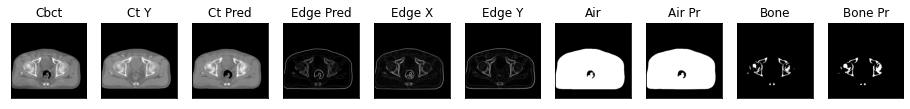

97it [01:02,  1.87it/s]

ssim score = 0.8687695860862732
psnr score = 24.090593338012695
snr score = 14.77804183959961
mae error = 0.02216986007988453
air dice score = 0.9958414872798468
bone dice score = 0.8288260121958914
contour dice score = 0.4236827790737152


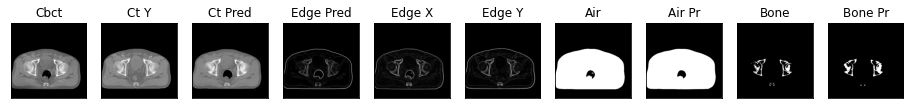

98it [01:03,  1.83it/s]

ssim score = 0.8654615879058838
psnr score = 24.009418487548828
snr score = 14.651771545410156
mae error = 0.02245298959314823
air dice score = 0.996135257772566
bone dice score = 0.8673899939742707
contour dice score = 0.44553378224372864


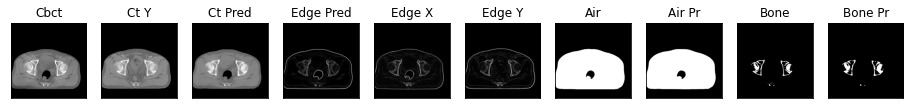

99it [01:03,  1.87it/s]

ssim score = 0.8600738048553467
psnr score = 23.516977310180664
snr score = 14.166003227233887
mae error = 0.023906521499156952
air dice score = 0.9959977317740683
bone dice score = 0.8884741017282863
contour dice score = 0.44262295961380005


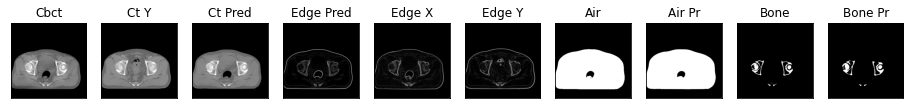

100it [01:04,  1.93it/s]

ssim score = 0.8621213436126709
psnr score = 23.232526779174805
snr score = 13.911659240722656
mae error = 0.024735471233725548
air dice score = 0.9960974163908544
bone dice score = 0.9240913970261603
contour dice score = 0.43169400095939636


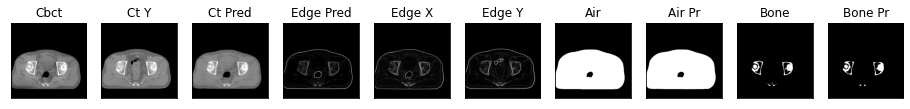

101it [01:04,  1.65it/s]

ssim score = 0.8665061593055725
psnr score = 23.838245391845703
snr score = 14.474791526794434
mae error = 0.023362115025520325
air dice score = 0.9955343558534516
bone dice score = 0.9130291005305385
contour dice score = 0.39868566393852234


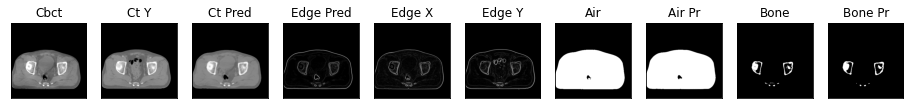

102it [01:05,  1.72it/s]

ssim score = 0.8682318329811096
psnr score = 24.12474822998047
snr score = 14.671091079711914
mae error = 0.021984269842505455
air dice score = 0.9962521463479096
bone dice score = 0.8920303940644632
contour dice score = 0.40876713395118713


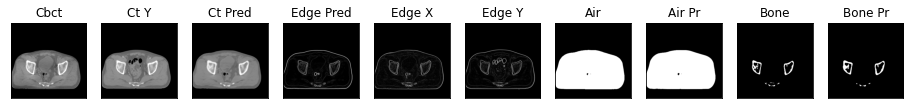

103it [01:06,  1.78it/s]

ssim score = 0.8690683841705322
psnr score = 23.76028823852539
snr score = 14.240903854370117
mae error = 0.02251184545457363
air dice score = 0.9962464967302848
bone dice score = 0.9086112681381456
contour dice score = 0.4076923131942749


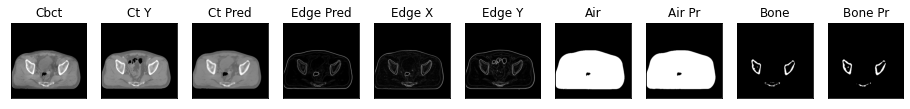

104it [01:06,  1.79it/s]

ssim score = 0.867963433265686
psnr score = 23.81779670715332
snr score = 14.298110961914062
mae error = 0.022478170692920685
air dice score = 0.9957717945915993
bone dice score = 0.9193854652180323
contour dice score = 0.3944903612136841


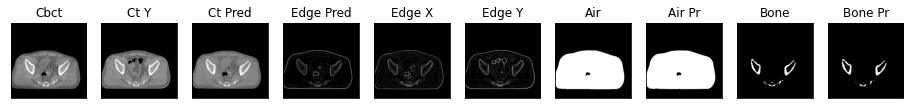

105it [01:07,  1.78it/s]

ssim score = 0.8622117638587952
psnr score = 23.53490447998047
snr score = 14.09138298034668
mae error = 0.024185916408896446
air dice score = 0.9956382274571073
bone dice score = 0.9051158723232019
contour dice score = 0.37700387835502625


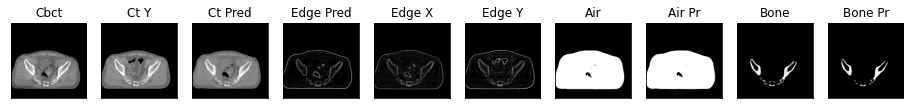

106it [01:07,  1.81it/s]

ssim score = 0.8677908778190613
psnr score = 23.884174346923828
snr score = 14.476234436035156
mae error = 0.02354838140308857
air dice score = 0.9957035354009928
bone dice score = 0.8966270654117625
contour dice score = 0.38321369886398315


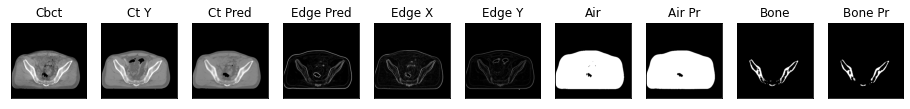

107it [01:08,  1.83it/s]

ssim score = 0.8670907616615295
psnr score = 24.55459976196289
snr score = 15.08496379852295
mae error = 0.022042391821742058
air dice score = 0.9956948036882078
bone dice score = 0.8798405466987494
contour dice score = 0.3638380467891693


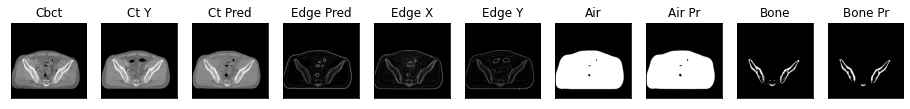

108it [01:08,  1.84it/s]

ssim score = 0.8654559254646301
psnr score = 24.455949783325195
snr score = 14.92505168914795
mae error = 0.02228773571550846
air dice score = 0.9952187093980119
bone dice score = 0.8805031446558358
contour dice score = 0.31596639752388


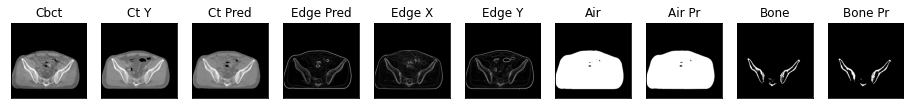

109it [01:09,  1.88it/s]

ssim score = 0.8112070560455322
psnr score = 22.474349975585938
snr score = 14.17165756225586
mae error = 0.0313628651201725
air dice score = 0.9945447414397637
bone dice score = 0.92873969375946
contour dice score = 0.2298850566148758


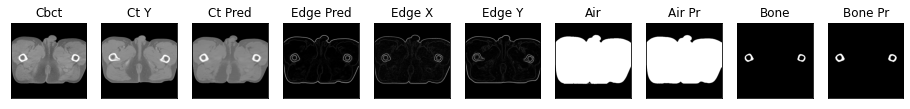

110it [01:09,  1.88it/s]

ssim score = 0.7998893857002258
psnr score = 22.12604331970215
snr score = 13.92763900756836
mae error = 0.03305767476558685
air dice score = 0.9942009966482859
bone dice score = 0.9261213720336116
contour dice score = 0.23162584006786346


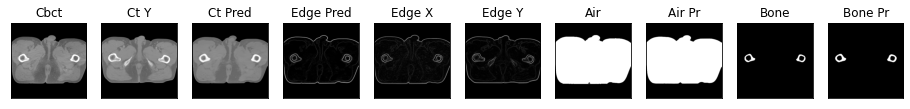

111it [01:10,  1.61it/s]

ssim score = 0.7927007079124451
psnr score = 21.807653427124023
snr score = 13.737207412719727
mae error = 0.03551853075623512
air dice score = 0.9943862253403347
bone dice score = 0.9032394664428702
contour dice score = 0.23307934403419495


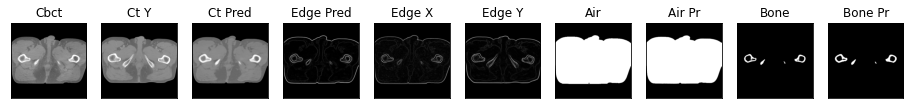

112it [01:11,  1.70it/s]

ssim score = 0.7813780307769775
psnr score = 21.439960479736328
snr score = 13.401803970336914
mae error = 0.037269242107868195
air dice score = 0.9945198559773543
bone dice score = 0.9129100016171771
contour dice score = 0.22371967136859894


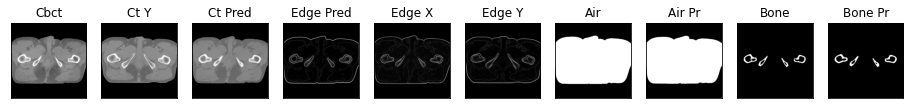

113it [01:11,  1.77it/s]

ssim score = 0.7730929255485535
psnr score = 21.29943084716797
snr score = 13.291511535644531
mae error = 0.03810535743832588
air dice score = 0.9945636254994115
bone dice score = 0.8849671105425162
contour dice score = 0.22402890026569366


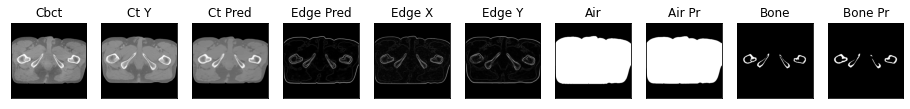

114it [01:12,  1.83it/s]

ssim score = 0.7655755281448364
psnr score = 21.191051483154297
snr score = 13.217549324035645
mae error = 0.03887151554226875
air dice score = 0.9946565910803061
bone dice score = 0.8929349517601473
contour dice score = 0.22704657912254333


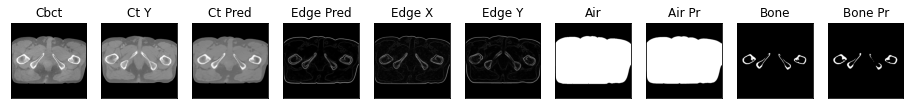

115it [01:12,  1.87it/s]

ssim score = 0.7599387168884277
psnr score = 20.888473510742188
snr score = 12.935281753540039
mae error = 0.04010429605841637
air dice score = 0.9948006932409043
bone dice score = 0.8973047684879433
contour dice score = 0.24616771936416626


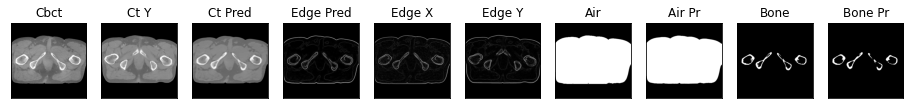

116it [01:13,  1.90it/s]

ssim score = 0.7590034604072571
psnr score = 20.852338790893555
snr score = 12.938220977783203
mae error = 0.04016166552901268
air dice score = 0.9938944690047032
bone dice score = 0.8942932154222151
contour dice score = 0.2602063715457916


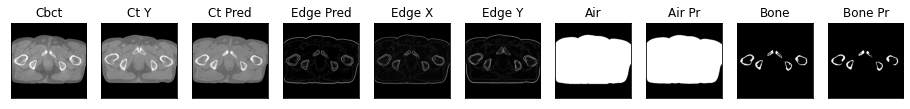

117it [01:13,  1.91it/s]

ssim score = 0.7563160061836243
psnr score = 20.876441955566406
snr score = 13.011002540588379
mae error = 0.04072584956884384
air dice score = 0.9934772633547698
bone dice score = 0.8979867585475207
contour dice score = 0.2598870098590851


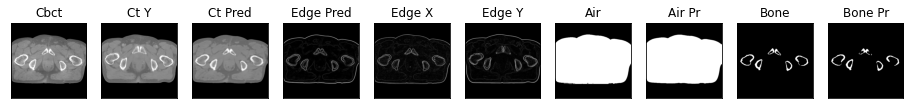

118it [01:14,  1.89it/s]

ssim score = 0.7463316321372986
psnr score = 20.661487579345703
snr score = 12.818660736083984
mae error = 0.042452532798051834
air dice score = 0.9936084616768972
bone dice score = 0.8798001052093661
contour dice score = 0.2450021207332611


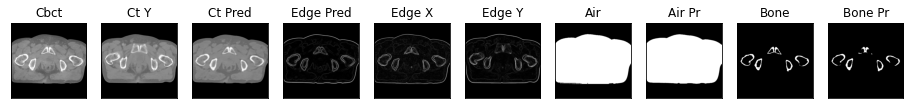

119it [01:14,  1.91it/s]

ssim score = 0.7358967065811157
psnr score = 20.635202407836914
snr score = 12.835153579711914
mae error = 0.04373421147465706
air dice score = 0.994155569585796
bone dice score = 0.856242912941209
contour dice score = 0.2427597939968109


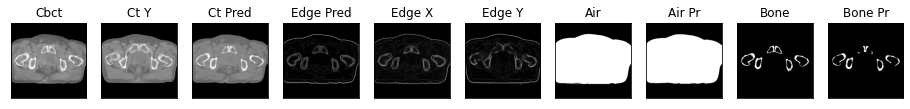

120it [01:15,  1.92it/s]

ssim score = 0.7391836643218994
psnr score = 20.642105102539062
snr score = 12.900390625
mae error = 0.04375705495476723
air dice score = 0.9940879646201667
bone dice score = 0.8546194073230142
contour dice score = 0.25999999046325684


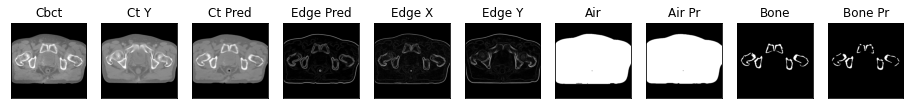

121it [01:16,  1.62it/s]

ssim score = 0.7360938191413879
psnr score = 20.625652313232422
snr score = 12.808571815490723
mae error = 0.044567618519067764
air dice score = 0.9947053938079669
bone dice score = 0.8090084180626542
contour dice score = 0.2557077705860138


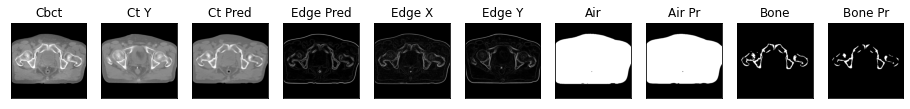

122it [01:16,  1.67it/s]

ssim score = 0.742683470249176
psnr score = 20.707286834716797
snr score = 12.782987594604492
mae error = 0.04366012662649155
air dice score = 0.9946427232727283
bone dice score = 0.7847935328841512
contour dice score = 0.25389552116394043


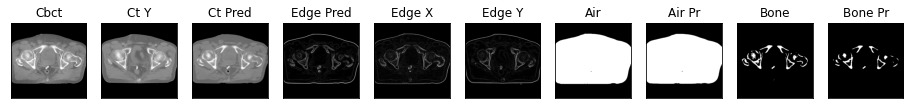

123it [01:17,  1.70it/s]

ssim score = 0.755862832069397
psnr score = 21.042362213134766
snr score = 12.994975090026855
mae error = 0.041818682104349136
air dice score = 0.9950945312680376
bone dice score = 0.7820778371330853
contour dice score = 0.2556321918964386


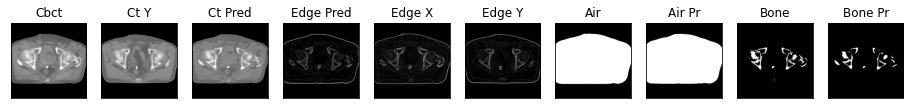

124it [01:17,  1.74it/s]

ssim score = 0.7618735432624817
psnr score = 21.240249633789062
snr score = 13.08043098449707
mae error = 0.040162377059459686
air dice score = 0.9952674087616606
bone dice score = 0.8407530454059716
contour dice score = 0.24630996584892273


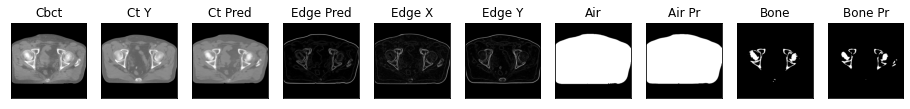

125it [01:18,  1.81it/s]

ssim score = 0.7573724985122681
psnr score = 21.425479888916016
snr score = 13.21501636505127
mae error = 0.038222599774599075
air dice score = 0.9953593595916264
bone dice score = 0.8725151253254914
contour dice score = 0.22902178764343262


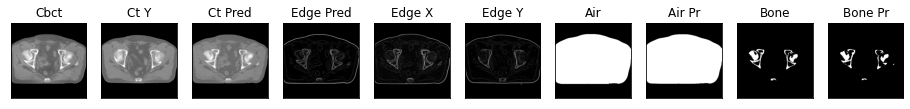

126it [01:18,  1.83it/s]

ssim score = 0.7555891275405884
psnr score = 21.21636962890625
snr score = 13.038058280944824
mae error = 0.0395786315202713
air dice score = 0.9954010408783457
bone dice score = 0.8701106169475411
contour dice score = 0.22822542488574982


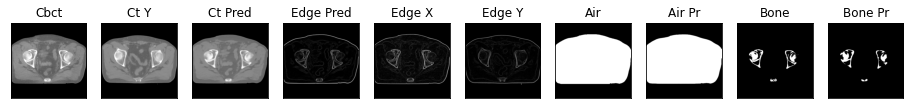

127it [01:19,  1.84it/s]

ssim score = 0.7572133541107178
psnr score = 21.03468894958496
snr score = 12.869854927062988
mae error = 0.04021824896335602
air dice score = 0.9953538930869463
bone dice score = 0.8856340778727494
contour dice score = 0.2133832424879074


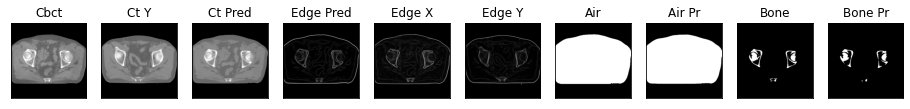

128it [01:19,  1.81it/s]

ssim score = 0.7550636529922485
psnr score = 20.6678466796875
snr score = 12.36152172088623
mae error = 0.04192586615681648
air dice score = 0.9952945737800285
bone dice score = 0.8961102904985708
contour dice score = 0.1849929243326187


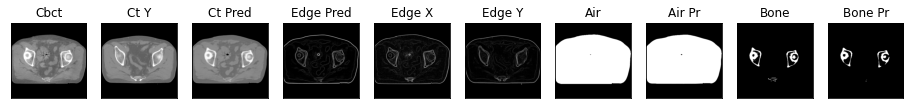

129it [01:20,  1.86it/s]

ssim score = 0.7645797729492188
psnr score = 20.806514739990234
snr score = 12.440881729125977
mae error = 0.04067312926054001
air dice score = 0.9952647489490368
bone dice score = 0.8991549295788851
contour dice score = 0.19611558318138123


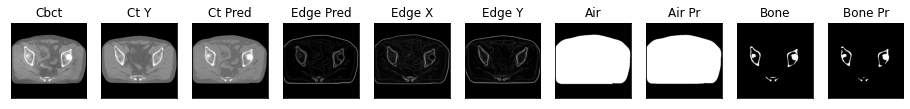

130it [01:20,  1.87it/s]

ssim score = 0.7629631757736206
psnr score = 21.095075607299805
snr score = 12.75508975982666
mae error = 0.0389273501932621
air dice score = 0.9952059427323782
bone dice score = 0.8614564831285709
contour dice score = 0.1922348439693451


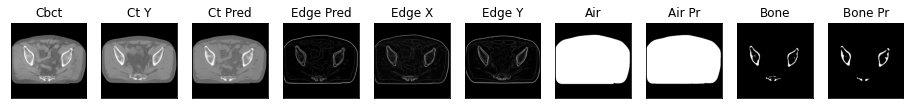

131it [01:21,  1.62it/s]

ssim score = 0.7554987668991089
psnr score = 20.949432373046875
snr score = 12.682258605957031
mae error = 0.03940656781196594
air dice score = 0.9948284192380449
bone dice score = 0.8874893617040427
contour dice score = 0.16880038380622864


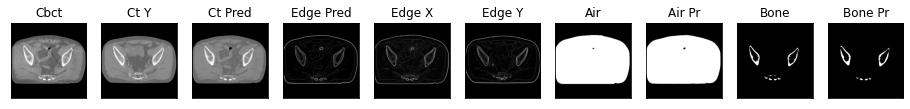

132it [01:22,  1.73it/s]

ssim score = 0.7482247948646545
psnr score = 20.546642303466797
snr score = 12.408699035644531
mae error = 0.041899725794792175
air dice score = 0.9949410995157169
bone dice score = 0.8892481810850567
contour dice score = 0.16610978543758392


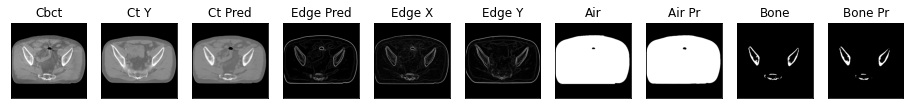

133it [01:22,  1.74it/s]

ssim score = 0.7410907745361328
psnr score = 20.353469848632812
snr score = 12.249486923217773
mae error = 0.04298781231045723
air dice score = 0.9947483430116776
bone dice score = 0.8840601732277152
contour dice score = 0.1557692289352417


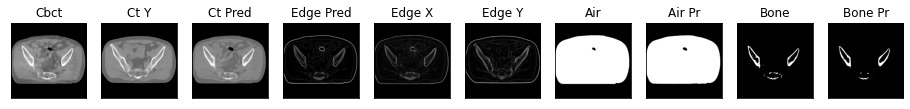

134it [01:23,  1.82it/s]

ssim score = 0.7293418645858765
psnr score = 20.41156768798828
snr score = 12.277793884277344
mae error = 0.04353600740432739
air dice score = 0.9947035501346844
bone dice score = 0.8767820773946438
contour dice score = 0.1610414683818817


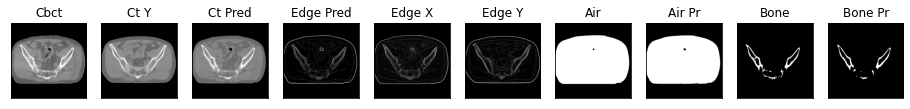

135it [01:23,  1.82it/s]

ssim score = 0.7299622297286987
psnr score = 20.729087829589844
snr score = 12.531939506530762
mae error = 0.04205814376473427
air dice score = 0.994996174259449
bone dice score = 0.8512709572762132
contour dice score = 0.16069699823856354


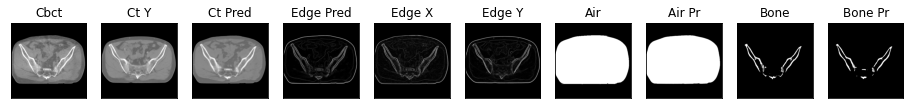

136it [01:24,  1.81it/s]

ssim score = 0.8369278907775879
psnr score = 22.673948287963867
snr score = 14.151339530944824
mae error = 0.030263517051935196
air dice score = 0.9965137110022549
bone dice score = 0.8402597402618148
contour dice score = 0.28456512093544006


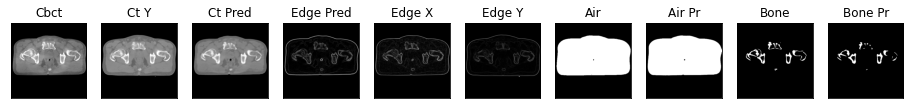

137it [01:24,  1.82it/s]

ssim score = 0.8362804651260376
psnr score = 22.5965518951416
snr score = 14.113954544067383
mae error = 0.03072810173034668
air dice score = 0.9967225814140596
bone dice score = 0.8250405624685635
contour dice score = 0.27662795782089233


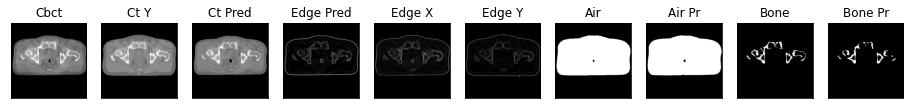

138it [01:25,  1.81it/s]

ssim score = 0.8366586565971375
psnr score = 22.715633392333984
snr score = 14.240822792053223
mae error = 0.030837515369057655
air dice score = 0.9968324004442116
bone dice score = 0.8148352405926536
contour dice score = 0.24632538855075836


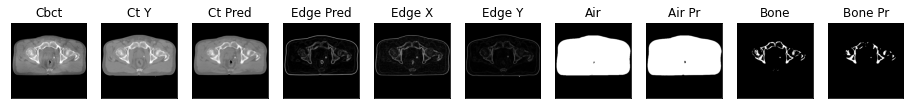

139it [01:25,  1.86it/s]

ssim score = 0.8372818827629089
psnr score = 22.662094116210938
snr score = 14.128862380981445
mae error = 0.030327366665005684
air dice score = 0.9967241559840271
bone dice score = 0.8375615297256398
contour dice score = 0.2601625919342041


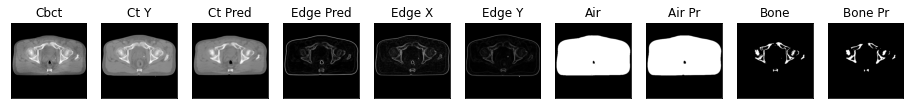

140it [01:26,  1.86it/s]

ssim score = 0.8430732488632202
psnr score = 22.852909088134766
snr score = 14.164054870605469
mae error = 0.027893582358956337
air dice score = 0.9969248769950821
bone dice score = 0.8484054172149642
contour dice score = 0.2469387799501419


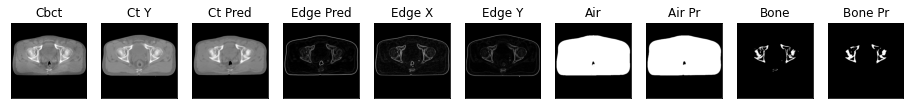

141it [01:27,  1.54it/s]

ssim score = 0.8478270173072815
psnr score = 22.974361419677734
snr score = 14.264705657958984
mae error = 0.027304334565997124
air dice score = 0.9968718982163828
bone dice score = 0.8665355436939234
contour dice score = 0.27737972140312195


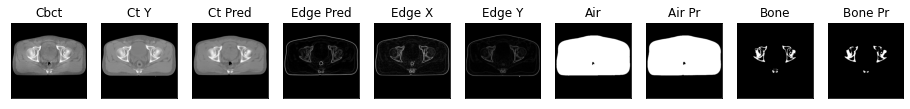

142it [01:27,  1.60it/s]

ssim score = 0.8463423252105713
psnr score = 22.97689437866211
snr score = 14.251607894897461
mae error = 0.02717953734099865
air dice score = 0.9966810487885853
bone dice score = 0.8811017180272552
contour dice score = 0.30010277032852173


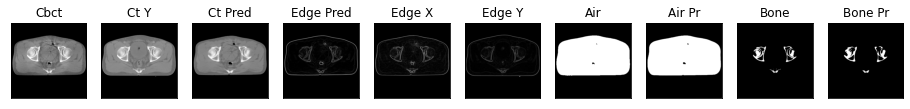

143it [01:28,  1.66it/s]

ssim score = 0.8422687649726868
psnr score = 22.49565315246582
snr score = 13.779729843139648
mae error = 0.028554018586874008
air dice score = 0.9968189047943673
bone dice score = 0.881270903011688
contour dice score = 0.34742268919944763


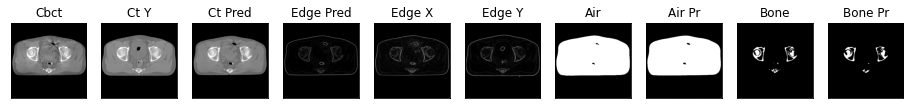

144it [01:29,  1.72it/s]

ssim score = 0.8370521068572998
psnr score = 22.420949935913086
snr score = 13.760807037353516
mae error = 0.029722537845373154
air dice score = 0.9966775392551038
bone dice score = 0.9120727673661512
contour dice score = 0.30522504448890686


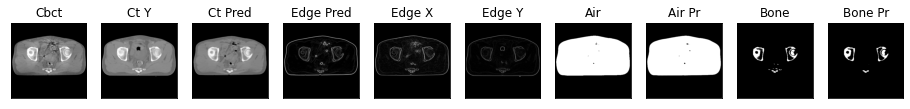

145it [01:29,  1.79it/s]

ssim score = 0.8370072841644287
psnr score = 22.170867919921875
snr score = 13.488797187805176
mae error = 0.03081110492348671
air dice score = 0.9963257714355437
bone dice score = 0.9191176470599672
contour dice score = 0.32536381483078003


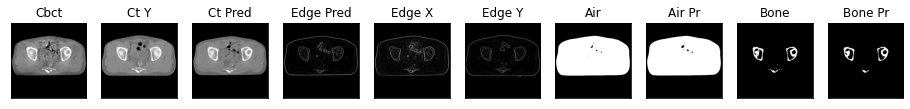

146it [01:30,  1.83it/s]

ssim score = 0.8360703587532043
psnr score = 21.704158782958984
snr score = 12.951313018798828
mae error = 0.03144065663218498
air dice score = 0.9962055142446248
bone dice score = 0.8967533466703069
contour dice score = 0.31419622898101807


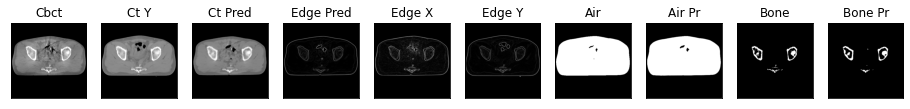

147it [01:30,  1.83it/s]

ssim score = 0.838316023349762
psnr score = 21.94413185119629
snr score = 13.147394180297852
mae error = 0.03054039366543293
air dice score = 0.9962718274169994
bone dice score = 0.8875912408777358
contour dice score = 0.30519139766693115


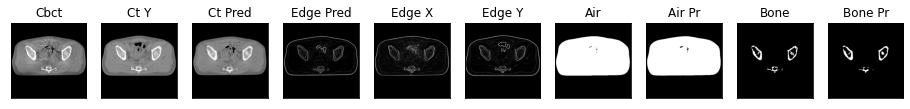

148it [01:31,  1.88it/s]

ssim score = 0.839981734752655
psnr score = 22.190338134765625
snr score = 13.392501831054688
mae error = 0.029626505449414253
air dice score = 0.9966817727936119
bone dice score = 0.9087668125116064
contour dice score = 0.3222748935222626


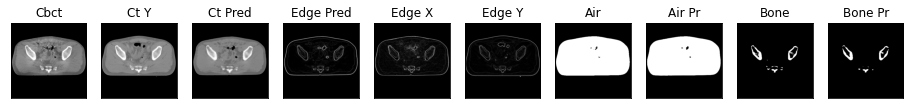

149it [01:31,  1.89it/s]

ssim score = 0.8363997340202332
psnr score = 22.13411521911621
snr score = 13.349637985229492
mae error = 0.030059797689318657
air dice score = 0.9960419415318411
bone dice score = 0.9136498981364418
contour dice score = 0.31418028473854065


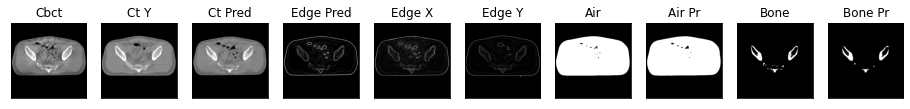

150it [01:32,  1.87it/s]

ssim score = 0.8351365327835083
psnr score = 22.05918312072754
snr score = 13.32990837097168
mae error = 0.030731655657291412
air dice score = 0.9960394044380403
bone dice score = 0.9004955135944758
contour dice score = 0.3720930218696594


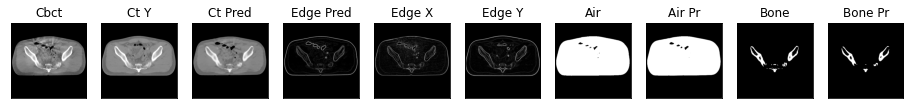

151it [01:33,  1.57it/s]

ssim score = 0.8370107412338257
psnr score = 21.762361526489258
snr score = 13.05245590209961
mae error = 0.03168650344014168
air dice score = 0.9957524130487146
bone dice score = 0.8807617996152255
contour dice score = 0.34957626461982727


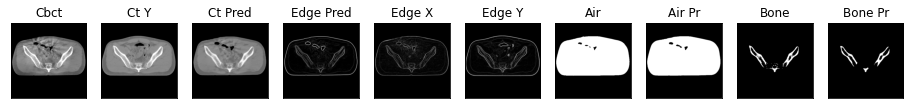

152it [01:33,  1.66it/s]

ssim score = 0.8397636413574219
psnr score = 21.908931732177734
snr score = 13.144289016723633
mae error = 0.03079410083591938
air dice score = 0.9953130334916385
bone dice score = 0.8894736842121422
contour dice score = 0.26567479968070984


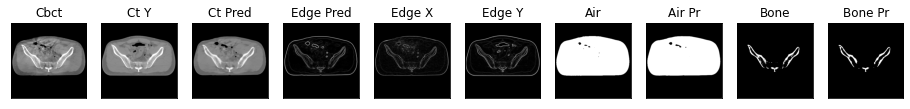

153it [01:34,  1.73it/s]

ssim score = 0.8424286246299744
psnr score = 22.211116790771484
snr score = 13.410123825073242
mae error = 0.029622038826346397
air dice score = 0.9958826676591718
bone dice score = 0.8642263380506894
contour dice score = 0.3199999928474426


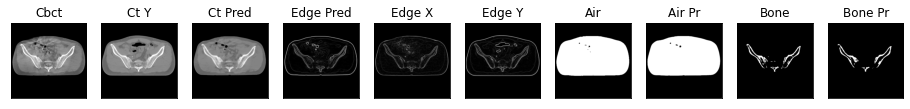

154it [01:34,  1.76it/s]

ssim score = 0.8445767164230347
psnr score = 22.295562744140625
snr score = 13.494636535644531
mae error = 0.029286053031682968
air dice score = 0.9958714243585994
bone dice score = 0.8635642517204711
contour dice score = 0.29566147923469543


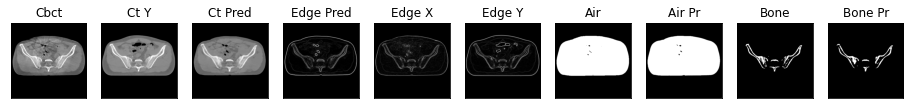

155it [01:35,  1.78it/s]

ssim score = 0.8435760140419006
psnr score = 22.402803421020508
snr score = 13.600459098815918
mae error = 0.028971966356039047
air dice score = 0.9959658927502694
bone dice score = 0.8598105909048979
contour dice score = 0.2983306348323822


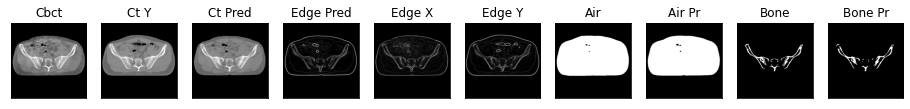

156it [01:35,  1.80it/s]

ssim score = 0.8363296985626221
psnr score = 21.906099319458008
snr score = 13.108793258666992
mae error = 0.030198650434613228
air dice score = 0.9949442147148359
bone dice score = 0.8647777628593423
contour dice score = 0.31618842482566833


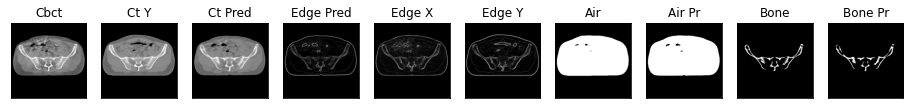

157it [01:36,  1.83it/s]

ssim score = 0.831271767616272
psnr score = 21.413246154785156
snr score = 12.598666191101074
mae error = 0.03171404078602791
air dice score = 0.9943237945903611
bone dice score = 0.847921225385012
contour dice score = 0.2662302255630493


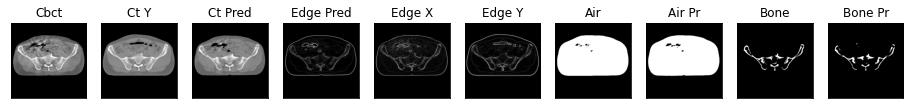

158it [01:36,  1.86it/s]

ssim score = 0.8251847624778748
psnr score = 21.23975372314453
snr score = 12.406548500061035
mae error = 0.03238266333937645
air dice score = 0.9949014917857408
bone dice score = 0.8494043887166219
contour dice score = 0.3095499575138092


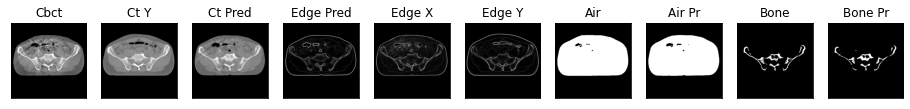

159it [01:37,  1.86it/s]

ssim score = 0.8155191540718079
psnr score = 20.9188175201416
snr score = 12.03967571258545
mae error = 0.033531252294778824
air dice score = 0.9945186870122938
bone dice score = 0.8285182889047921
contour dice score = 0.2852404713630676


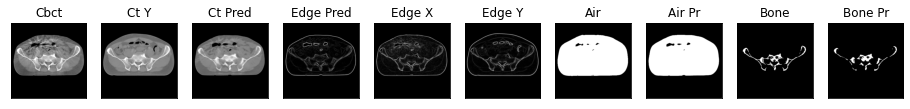

160it [01:37,  1.85it/s]

ssim score = 0.8110249042510986
psnr score = 20.944862365722656
snr score = 12.011920928955078
mae error = 0.033438391983509064
air dice score = 0.9943385454660834
bone dice score = 0.8520503552305615
contour dice score = 0.3055555522441864


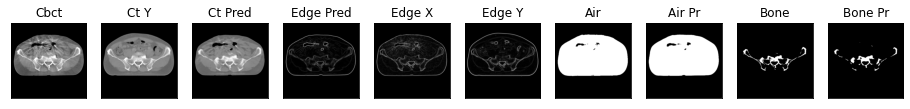

161it [01:38,  1.59it/s]

ssim score = 0.803535521030426
psnr score = 20.583036422729492
snr score = 11.680559158325195
mae error = 0.03522104024887085
air dice score = 0.9944664283382609
bone dice score = 0.840035295602672
contour dice score = 0.325529545545578


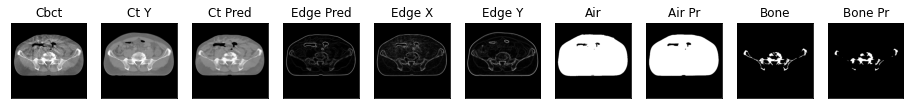

162it [01:39,  1.66it/s]

ssim score = 0.79848712682724
psnr score = 20.380151748657227
snr score = 11.42245101928711
mae error = 0.03528067097067833
air dice score = 0.9945911447945796
bone dice score = 0.8419695797906424
contour dice score = 0.3040089011192322


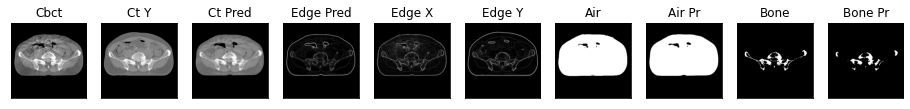

163it [01:39,  1.74it/s]

ssim score = 0.8085353374481201
psnr score = 21.086423873901367
snr score = 11.981189727783203
mae error = 0.0316665954887867
air dice score = 0.9947781929673319
bone dice score = 0.8578174186797243
contour dice score = 0.23180291056632996


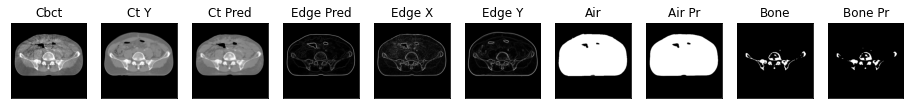

164it [01:40,  1.80it/s]

ssim score = 0.8572158217430115
psnr score = 24.686695098876953
snr score = 15.067606925964355
mae error = 0.02283642813563347
air dice score = 0.9951291622011197
bone dice score = 0.8770053475965726
contour dice score = 0.3106796145439148


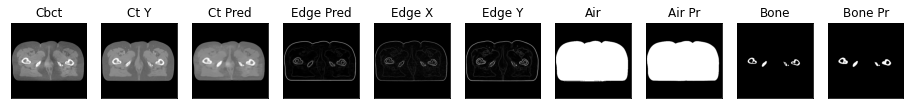

165it [01:40,  1.82it/s]

ssim score = 0.858512818813324
psnr score = 24.940845489501953
snr score = 15.442770957946777
mae error = 0.02232946641743183
air dice score = 0.9950150868872595
bone dice score = 0.8815953469073204
contour dice score = 0.3107372522354126


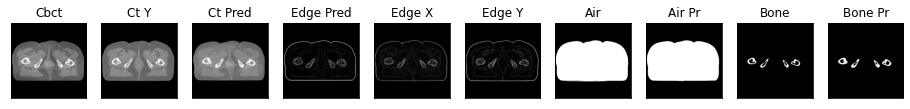

166it [01:41,  1.83it/s]

ssim score = 0.8552147746086121
psnr score = 24.96783447265625
snr score = 15.552675247192383
mae error = 0.02245723269879818
air dice score = 0.9950163810024188
bone dice score = 0.8835525061962349
contour dice score = 0.2963325083255768


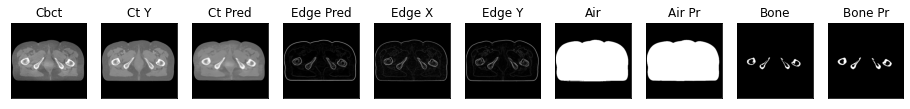

167it [01:41,  1.84it/s]

ssim score = 0.8517491221427917
psnr score = 24.886306762695312
snr score = 15.53459644317627
mae error = 0.022787244990468025
air dice score = 0.9949529791946589
bone dice score = 0.8976863753230903
contour dice score = 0.2981427311897278


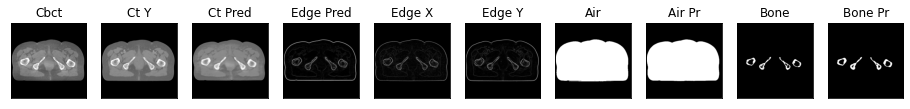

168it [01:42,  1.89it/s]

ssim score = 0.8490107655525208
psnr score = 24.73800277709961
snr score = 15.414752006530762
mae error = 0.02319769561290741
air dice score = 0.9949558181778744
bone dice score = 0.9156666666680722
contour dice score = 0.28852781653404236


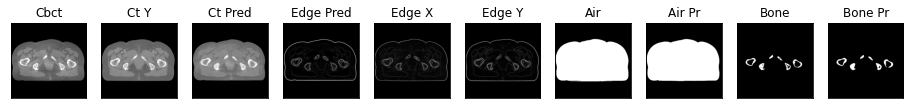

169it [01:42,  1.93it/s]

ssim score = 0.8505091071128845
psnr score = 24.671260833740234
snr score = 15.370962142944336
mae error = 0.02300851047039032
air dice score = 0.9947007436286227
bone dice score = 0.9106368211016721
contour dice score = 0.26023390889167786


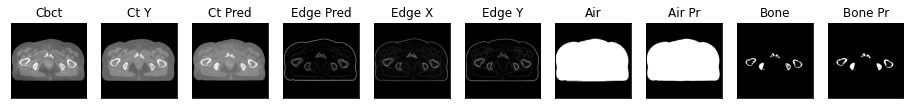

170it [01:43,  1.99it/s]

ssim score = 0.8482620716094971
psnr score = 24.60898208618164
snr score = 15.340009689331055
mae error = 0.023018496111035347
air dice score = 0.9945973202708582
bone dice score = 0.9031708148669763
contour dice score = 0.25544267892837524


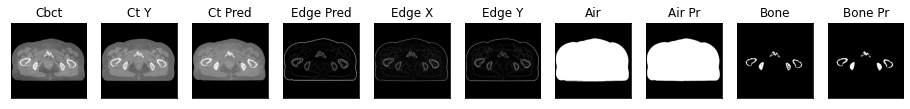

171it [01:44,  1.64it/s]

ssim score = 0.8442903161048889
psnr score = 24.242345809936523
snr score = 15.021739959716797
mae error = 0.023901071399450302
air dice score = 0.9946910294223476
bone dice score = 0.8883682008386884
contour dice score = 0.3013182580471039


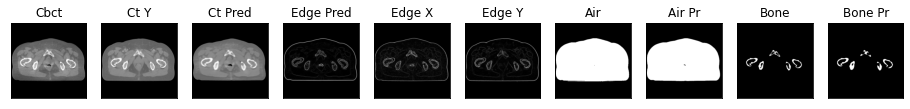

172it [01:44,  1.68it/s]

ssim score = 0.8459590673446655
psnr score = 24.07564353942871
snr score = 14.897780418395996
mae error = 0.023911744356155396
air dice score = 0.9946014424945694
bone dice score = 0.8994999193434505
contour dice score = 0.30591630935668945


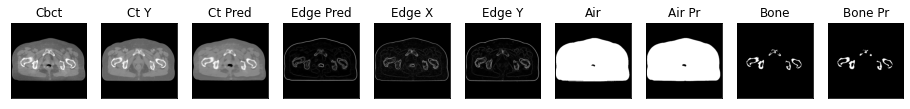

173it [01:45,  1.72it/s]

ssim score = 0.8430736064910889
psnr score = 23.961467742919922
snr score = 14.871307373046875
mae error = 0.02420506812632084
air dice score = 0.9946593346481102
bone dice score = 0.8718545454564094
contour dice score = 0.3283442556858063


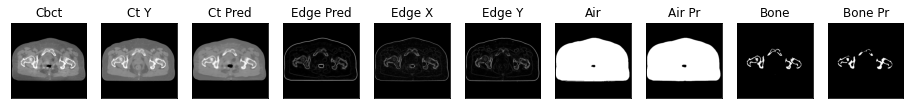

174it [01:45,  1.80it/s]

ssim score = 0.8481287360191345
psnr score = 24.79837417602539
snr score = 15.821487426757812
mae error = 0.02275838889181614
air dice score = 0.9943838736944696
bone dice score = 0.8705941591154256
contour dice score = 0.3113164007663727


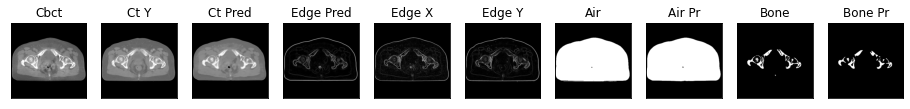

175it [01:46,  1.85it/s]

ssim score = 0.8479611873626709
psnr score = 24.10521697998047
snr score = 14.999778747558594
mae error = 0.023322755470871925
air dice score = 0.99398334290638
bone dice score = 0.8698619008956968
contour dice score = 0.3277931809425354


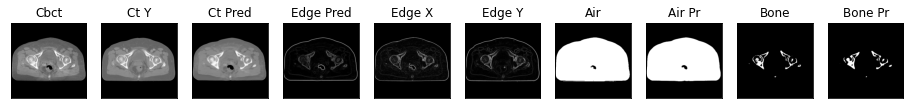

176it [01:46,  1.84it/s]

ssim score = 0.8489881753921509
psnr score = 24.206462860107422
snr score = 14.991600036621094
mae error = 0.02279794216156006
air dice score = 0.9941402187556075
bone dice score = 0.8567798148510296
contour dice score = 0.3241475820541382


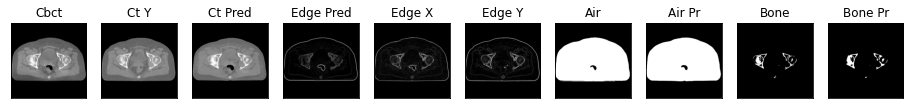

177it [01:47,  1.83it/s]

ssim score = 0.851366400718689
psnr score = 24.242111206054688
snr score = 15.000123023986816
mae error = 0.023494072258472443
air dice score = 0.9943810585914084
bone dice score = 0.8955223880614341
contour dice score = 0.35321101546287537


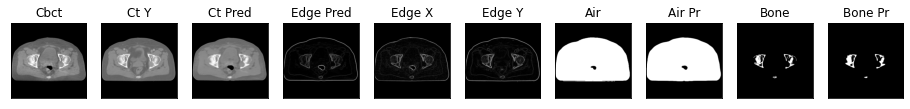

178it [01:47,  1.86it/s]

ssim score = 0.8565799593925476
psnr score = 24.827621459960938
snr score = 15.577627182006836
mae error = 0.02320980466902256
air dice score = 0.9948195341124149
bone dice score = 0.9049284578711458
contour dice score = 0.3338008522987366


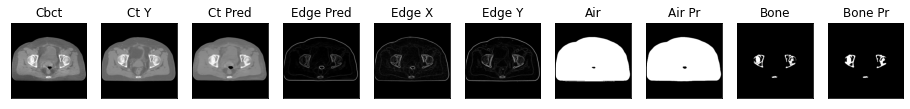

179it [01:48,  1.90it/s]

ssim score = 0.8578327894210815
psnr score = 25.51529312133789
snr score = 16.299531936645508
mae error = 0.022161468863487244
air dice score = 0.9953852961628454
bone dice score = 0.9098907767003961
contour dice score = 0.31559115648269653


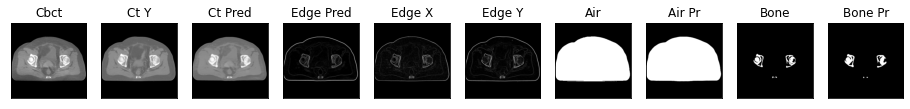

180it [01:48,  1.90it/s]

ssim score = 0.8545477390289307
psnr score = 25.064485549926758
snr score = 15.900212287902832
mae error = 0.023268038406968117
air dice score = 0.9956633898068774
bone dice score = 0.9308568752937278
contour dice score = 0.3159922957420349


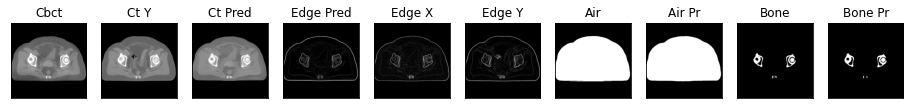

181it [01:49,  1.61it/s]

ssim score = 0.8414919972419739
psnr score = 24.290502548217773
snr score = 15.163788795471191
mae error = 0.024459250271320343
air dice score = 0.9959206250432165
bone dice score = 0.9210124002051807
contour dice score = 0.3134978115558624


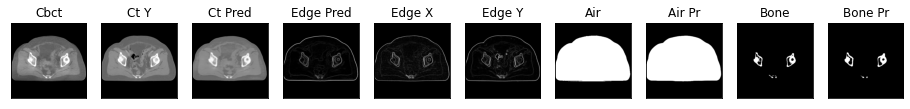

182it [01:50,  1.69it/s]

ssim score = 0.8240756988525391
psnr score = 22.776931762695312
snr score = 13.577783584594727
mae error = 0.027980076149106026
air dice score = 0.9954985246689113
bone dice score = 0.8726758286201965
contour dice score = 0.31847134232521057


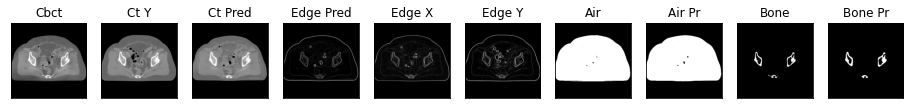

183it [01:50,  1.75it/s]

ssim score = 0.8133309483528137
psnr score = 22.382795333862305
snr score = 13.165653228759766
mae error = 0.030054500326514244
air dice score = 0.9953028565186552
bone dice score = 0.8869170449878886
contour dice score = 0.32360216975212097


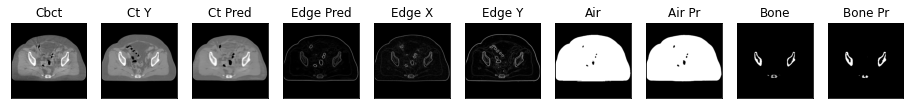

184it [01:51,  1.80it/s]

ssim score = 0.8116337656974792
psnr score = 22.94229507446289
snr score = 13.790064811706543
mae error = 0.02915961481630802
air dice score = 0.995576924375539
bone dice score = 0.8932391523734967
contour dice score = 0.28952568769454956


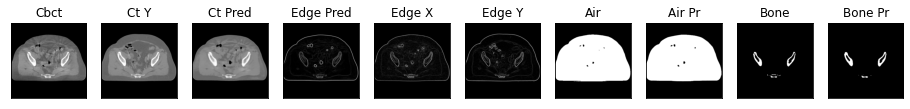

185it [01:51,  1.86it/s]

ssim score = 0.8101987838745117
psnr score = 23.08835220336914
snr score = 13.991217613220215
mae error = 0.029174679890275
air dice score = 0.9952072400128553
bone dice score = 0.9103154909622418
contour dice score = 0.292974591255188


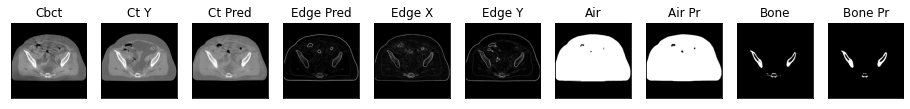

186it [01:52,  1.90it/s]

ssim score = 0.8027533888816833
psnr score = 22.404632568359375
snr score = 13.371929168701172
mae error = 0.0314798429608345
air dice score = 0.9952002757852619
bone dice score = 0.9084715639823983
contour dice score = 0.2784062922000885


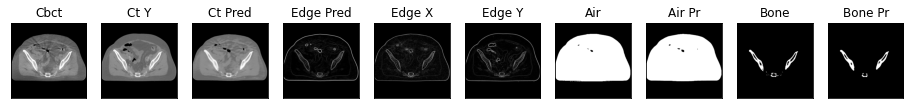

187it [01:52,  1.91it/s]

ssim score = 0.7995737195014954
psnr score = 22.255584716796875
snr score = 13.295740127563477
mae error = 0.031951744109392166
air dice score = 0.9952121012824761
bone dice score = 0.8852190528199096
contour dice score = 0.25246548652648926


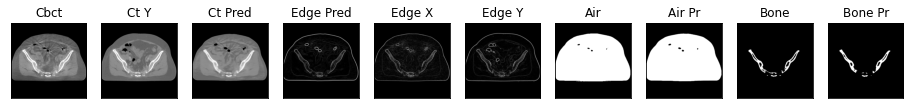

188it [01:53,  1.87it/s]

ssim score = 0.7970725297927856
psnr score = 22.135522842407227
snr score = 13.171387672424316
mae error = 0.032421424984931946
air dice score = 0.9944781672214643
bone dice score = 0.8610885458995249
contour dice score = 0.2628236413002014


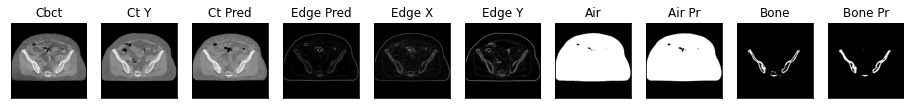

189it [01:53,  1.90it/s]

ssim score = 0.7995285987854004
psnr score = 22.3044490814209
snr score = 13.318137168884277
mae error = 0.032288625836372375
air dice score = 0.9953024947823477
bone dice score = 0.8759607739216013
contour dice score = 0.24101069569587708


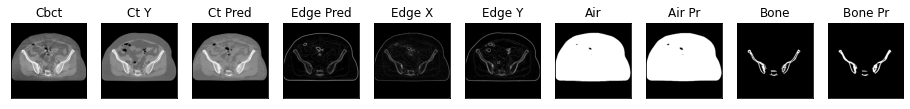

190it [01:54,  1.96it/s]

ssim score = 0.8052128553390503
psnr score = 22.926639556884766
snr score = 13.951961517333984
mae error = 0.030724171549081802
air dice score = 0.9954790538031048
bone dice score = 0.8893286219096914
contour dice score = 0.23864734172821045


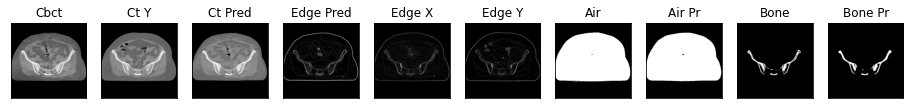

191it [01:55,  1.66it/s]


In [45]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [46]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [47]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [48]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:30,  6.30it/s]


(0.8376503761526177,
 23.28367394052875,
 14.287945852229733,
 0.027986927260279033,
 0.9949415224266396,
 0.879172175874427,
 0.3255242123341685,
 0.5,
 0.5)

In [49]:
# import torchvision.models as models
# models.vgg16(pretrained=True)